In [1]:
import numpy as np , pandas as pd
from matplotlib.pyplot import subplots
import statsmodels.api as sm
from ISLP import load_data
from ISLP.models import (summarize , poly, ModelSpec as MS)
from statsmodels.stats.anova import anova_lm

In [2]:
from pygam import (s as s_gam, l as l_gam, f as f_gam, LinearGAM, LogisticGAM)
from ISLP.transforms import (BSpline ,NaturalSpline)
from ISLP.models import bs , ns
from ISLP.pygam import (approx_lam , degrees_of_freedom , plot as plot_gam , anova as anova_gam)

## 7.8.1 Polynomial Regression and Step Functions

In [3]:
Wage = load_data('Wage')
Wage.head()

,year,age,maritl,race,education,region,jobclass,health,health_ins,logwage,wage
0,2006,18,1. Never Married,1. White,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.318063,75.043154
1,2004,24,1. Never Married,1. White,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,2. No,4.255273,70.476020
2,2003,45,2. Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,1. <=Good,1. Yes,4.875061,130.982177
3,2003,43,2. Married,3. Asian,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,1. Yes,5.041393,154.685293
4,2005,50,4. Divorced,1. White,2. HS Grad,2. Middle Atlantic,2. Information,1. <=Good,1. Yes,4.318063,75.043154


In [4]:
y = Wage['wage']
age = Wage['age']

In [5]:
poly_age = MS([ poly('age', degree =4)]).fit(Wage)
M = sm.OLS(y, poly_age.transform(Wage)).fit()
summarize(M)

,coef,std err,t,P>|t|
intercept,111.7036,0.729,153.283,0.000
"poly(age, degree=4)[0]",447.0679,39.915,11.201,0.000
"poly(age, degree=4)[1]",-478.3158,39.915,-11.983,0.000
"poly(age, degree=4)[2]",125.5217,39.915,3.145,0.002
"poly(age, degree=4)[3]",-77.9112,39.915,-1.952,0.051



## 1. `poly_age = MS([poly('age', degree=4)]).fit(Wage)`

This line creates and prepares a polynomial transformation for the age feature in the Wage dataset.

### `poly('age', degree=4)`
- The `poly()` function from the ISLP.models module is a helper function that generates a `Poly()` transformer (using scikit-learn terminology)
- This transformer creates polynomial features for the specified column (age) up to the specified degree (here, 4)
- For a 4th-degree polynomial, it generates features corresponding to age, age², age³, and age⁴
- These are the terms used in polynomial regression to model a nonlinear relationship between age and wage
- For example, if age = 30, the transformer would generate the values [30, 30², 30³, 30⁴] (i.e., [30, 900, 27000, 810000]) for that observation

### `MS([poly('age', degree=4)])`
- MS (short for ModelSpec) is a class from ISLP.models that wraps scikit-learn-style feature transformations (like `Poly()`) to define a model specification
- Here, MS takes a list containing the `poly('age', degree=4)` transformer, indicating that the model will use the polynomial features of age up to degree 4
- MS is essentially a container for specifying which features (and their transformations) to include in the model

### `.fit(Wage)`
- The `fit()` method is called on the ModelSpec object with the Wage DataFrame as input
- This step "fits" the transformer to the data, meaning it computes any necessary parameters for the transformation based on the Wage DataFrame
- For polynomial regression, `Poly()` doesn't require much preprocessing (unlike, say, standardization, which needs mean and variance), but `fit()` ensures the transformer is ready to process the age column
- The result, `poly_age`, is a fitted ModelSpec object that knows how to transform the age column into polynomial features

## 2. `M = sm.OLS(y, poly_age.transform(Wage)).fit()`

This line builds and fits a linear regression model using the polynomial features.

### `poly_age.transform(Wage)`
- The `transform()` method applies the polynomial transformation defined by `poly_age` to the Wage DataFrame
- It takes the age column from Wage and generates a matrix where each row corresponds to an observation, and the columns are the polynomial terms [age, age², age³, age⁴]
- For example, if Wage has 3000 rows (observations), the output of `poly_age.transform(Wage)` is a matrix with 3000 rows and 4 columns (one for each polynomial term)

### `sm.OLS(y, poly_age.transform(Wage))`
- `sm.OLS` is a function from the statsmodels.api module that sets up an Ordinary Least Squares (OLS) linear regression model
- `y` is the response variable (Wage['wage']), the target we want to predict
- `poly_age.transform(Wage)` provides the design matrix (the polynomial features of age)
- This line specifies a regression model where wage is modeled as a linear combination of age, age², age³, and age⁴

**Mathematically, the model is:**
```
wage = β₀ + β₁ · age + β₂ · age² + β₃ · age³ + β₄ · age⁴ + ε
```

where β₀, β₁, ..., β₄ are the coefficients to be estimated, and ε is the error term.

### `.fit()`
- The `fit()` method on the OLS object estimates the regression coefficients (β₀, β₁, ..., β₄) by minimizing the sum of squared residuals between the observed wage values and the predicted values
- The result, `M`, is a fitted OLS model object containing the estimated coefficients, standard errors, p-values, and other regression diagnostics

## 3. `summarize(M)`

The `summarize()` function (from ISLP.models) is a utility function that displays a concise summary of the fitted model M.

It typically outputs a table with:
- The estimated coefficients for each polynomial term (age, age², age³, age⁴)
- Standard errors for each coefficient
- t-statistics and p-values to test the significance of each coefficient
- Other metrics like the R-squared value may also be included

This summary helps you interpret the model, e.g., which polynomial terms are statistically significant in predicting wage.

In [6]:
age_grid = np.linspace(age.min(), age.max(), 100)
age_df = pd.DataFrame ({'age': age_grid })

In [10]:
age_df

,age
0,18.000000
1,18.626263
2,19.252525
3,19.878788
4,20.505051
...,...
95,77.494949
96,78.121212
97,78.747475
98,79.373737



## 1. `age_grid = np.linspace(age.min(), age.max(), 100)`

**What it does:**
- `np.linspace(start, stop, num)` is a NumPy function that creates an array of `num` evenly spaced values between `start` and `stop` (inclusive)
- Here, `age.min()` is the minimum value of the age column in the Wage DataFrame, and `age.max()` is the maximum value
- `num=100` specifies that 100 evenly spaced points are generated between these minimum and maximum ages
- The result, `age_grid`, is a NumPy array containing 100 age values spanning the range of age in the dataset

## 2. `age_df = pd.DataFrame({'age': age_grid})`

**What it does:**
- This line converts the `age_grid` NumPy array into a pandas DataFrame with a single column named 'age'
- The resulting `age_df` is a DataFrame with 100 rows (one for each value in `age_grid`) and one column (age)

## Why Do We Have These Lines?

These two lines are critical for visualizing the fitted polynomial regression model (likely to create a plot like Figure 7.1 in the book). Here's why they are necessary:

### 1. Creating a Smooth Curve:
- The original age values in the Wage dataset may be scattered or unevenly distributed (e.g., more data points at certain ages). If you only predicted wage at these observed ages, the resulting plot might look jagged or incomplete
- By generating a grid of 100 evenly spaced age values with `np.linspace()`, you ensure a smooth, continuous curve that shows how the fitted polynomial model predicts wage across the entire range of ages

### 2. Compatibility with the Model:
- The `poly_age` object (from `MS([poly('age', degree=4)])`) is designed to work with a pandas DataFrame, as it was fitted on the Wage DataFrame. To apply the same polynomial transformation (i.e., compute age, age², age³, age⁴) to new age values, you need a DataFrame with an age column. Hence, `age_grid` (a NumPy array) is converted to `age_df` (a DataFrame)

In [13]:
def plot_wage_fit(age_df, basis, title):
    X = basis.transform(Wage)
    Xnew = basis.transform(age_df)
    M = sm.OLS(y, X).fit()
    preds = M.get_prediction(Xnew)
    bands = preds.conf_int(alpha =0.05)
    fig , ax = subplots(figsize =(8 ,8))
    ax.scatter(age , y, facecolor='gray',alpha =0.5)

    for val , ls in zip([ preds.predicted_mean ,bands [:,0], bands [:,1]],['b','r--','r--']):
        ax.plot(age_df.values , val , ls , linewidth =3)
    ax.set_title(title , fontsize =20)
    ax.set_xlabel('Age', fontsize =20)
    ax.set_ylabel('Wage ', fontsize =20)
    return ax

<Axes: title={'center': 'Degree -4 Polynomial'}, xlabel='Age', ylabel='Wage '>

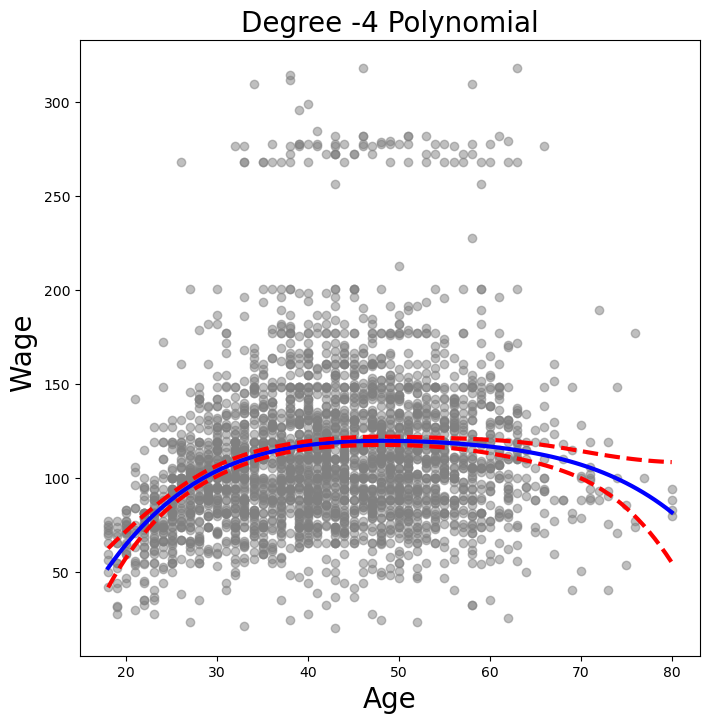

In [14]:
plot_wage_fit(age_df , poly_age, 'Degree -4 Polynomial')

## Breakdown of plot_wage_fit Function

The `plot_wage_fit` function is a reusable utility to plot the fitted regression model, including the predicted values and 95% confidence bands, for a given feature transformation (e.g., polynomial or spline). It takes three arguments:

- `age_df`: A pandas DataFrame containing a grid of age values (from the previous code: `pd.DataFrame({'age': age_grid})`)
- `basis`: A fitted ModelSpec object (e.g., `poly_age` for the 4th-degree polynomial)
- `title`: A string for the plot's title (e.g., 'Degree-4 Polynomial')

Let's break down each line of the function.

## 1. `X = basis.transform(Wage)`

**What it does:**
- Applies the transformation defined by `basis` to the Wage DataFrame
- Here, `basis` is `poly_age` (from `MS([poly('age', degree=4)]).fit(Wage)`), so it transforms the age column in Wage into polynomial features: [age, age², age³, age⁴]
- The result, `X`, is a matrix with one row per observation in Wage and four columns (one for each polynomial term)

**Why:**
- This creates the design matrix for fitting the regression model, using the original Wage data to estimate the model coefficients

## 2. `Xnew = basis.transform(age_df)`

**What it does:**
- Applies the same transformation (e.g., polynomial features) to `age_df`, the DataFrame containing the grid of 100 age values (from `age_grid`)
- `Xnew` is a matrix with 100 rows (one for each grid point) and four columns (the polynomial terms for each age value in `age_df`)

**Why:**
- This generates the polynomial features for the grid of age values, which will be used to predict wage values for plotting the smooth fitted curve

## 3. `M = sm.OLS(y, X).fit()`

**What it does:**
- Fits an Ordinary Least Squares (OLS) regression model using statsmodels
- `y` is the response variable (Wage['wage']), and `X` is the design matrix of polynomial features from the Wage data
- The `fit()` method estimates the coefficients (β₀, β₁, β₂, β₃, β₄) for the model:

```
wage = β₀ + β₁ · age + β₂ · age² + β₃ · age³ + β₄ · age⁴ + ε
```

- `M` is the fitted model object

**Why:**
- This refits the polynomial regression model. Note that this step is redundant if you're using the same `poly_age` and Wage data as in the earlier code (`M = sm.OLS(y, poly_age.transform(Wage)).fit()`). The lab includes this step to make the function self-contained and reusable for different transformations (e.g., splines later in the chapter)

## 4. `preds = M.get_prediction(Xnew)`

**What it does:**
- Uses the fitted model `M` to predict wage values for the polynomial features in `Xnew` (the transformed grid points in `age_df`)
- `M.get_prediction()` returns a statsmodels prediction object containing predicted values and additional statistics (e.g., confidence intervals)

**Why:**
- This generates the predicted wage values for the 100 age grid points, which will be plotted as the smooth polynomial curve

## 5. `bands = preds.conf_int(alpha=0.05)`

**What it does:**
- Extracts the 95% confidence intervals for the predicted wage values from `preds`
- `alpha=0.05` specifies a 95% confidence level (i.e., 1 - 0.05)
- `bands` is a matrix with 100 rows (one for each grid point) and two columns: the lower and upper bounds of the confidence intervals

**Why:**
- Confidence intervals show the uncertainty around the predicted wage values, indicating where the true polynomial curve is likely to lie with 95% confidence. These will be plotted as dashed lines around the fitted curve

## 6. `fig, ax = subplots(figsize=(8, 8))`

**What it does:**
- Creates a new figure and axis object using `matplotlib.pyplot.subplots()`
- `figsize=(8, 8)` sets the figure size to 8x8 inches

**Why:**
- This initializes the plot where the data and fitted curve will be visualized

## 7. `ax.scatter(age, y, facecolor='gray', alpha=0.5)`

**What it does:**
- Creates a scatter plot of the original data: `age` (x-axis) vs. `y` (Wage['wage'], y-axis)
- `facecolor='gray'` sets the color of the points to gray
- `alpha=0.5` adds transparency (50%) to the points, making overlapping points visually indicate density

**Why:**
- This plots the raw data points to show the observed relationship between age and wage. Transparency helps visualize areas with many overlapping points (e.g., ages with more observations)

## 8. `for val, ls in zip([preds.predicted_mean, bands[:,0], bands[:,1]], ['b', 'r--', 'r--']):`

**What it does:**
- This line starts a loop that iterates over three arrays paired with their corresponding line styles:
  - `preds.predicted_mean`: The predicted wage values for the grid points (the fitted polynomial curve)
  - `bands[:,0]`: The lower bounds of the 95% confidence intervals
  - `bands[:,1]`: The upper bounds of the 95% confidence intervals
  - `['b', 'r--', 'r--']`: Line styles for plotting—'b' (solid blue line) for the predicted mean, 'r--' (dashed red line) for both confidence bounds
- The `zip()` function pairs each array with its line style, so `val` is the array to plot, and `ls` is the line style

**Why:**
- This sets up the plotting of the fitted curve and its confidence bands. The `zip()` function is used for convenience to iterate over the three lines (predicted mean and two confidence bounds) in a single loop

## 9. `ax.plot(age_df.values, val, ls, linewidth=3)`

**What it does:**
- Plots a line on the axis `ax`:
  - `age_df.values`: The x-values (the 100 age grid points from `age_df`)
  - `val`: The y-values (either the predicted wage values or the confidence bounds)
  - `ls`: The line style ('b' for the mean, 'r--' for the bounds)
  - `linewidth=3`: Sets the line thickness to 3 for visibility

**Why:**
- This plots the fitted polynomial curve (blue solid line) and the 95% confidence bands (red dashed lines) over the range of age values

## 10. `ax.set_title(title, fontsize=20)`

**What it does:**
- Sets the plot's title to the `title` argument (e.g., 'Degree-4 Polynomial')
- `fontsize=20` sets the title font size

**Why:**
- Provides a descriptive title for the plot, indicating the type of model (e.g., 4th-degree polynomial)

## 11. `ax.set_xlabel('Age', fontsize=20)`

**What it does:**
- Labels the x-axis as 'Age' with a font size of 20

**Why:**
- Clearly identifies the x-axis variable for the viewer

## 12. `ax.set_ylabel('Wage', fontsize=20)`

**What it does:**
- Labels the y-axis as 'Wage' with a font size of 20

**Why:**
- Clearly identifies the y-axis variable (the response variable)

## 13. `return ax`

**What it does:**
- Returns the `ax` object (the matplotlib axis containing the plot)

**Why:**
- Allows the caller to further customize the plot if needed (e.g., adding legends or saving the figure). In the lab, this return value may not be used directly, but it's good practice for reusable functions

## Why Do We Have These Lines?

### 1. Visualization of the Model:
- The `plot_wage_fit` function creates a plot to visualize the fitted polynomial regression model, showing both the predicted wage values (as a smooth curve) and the uncertainty (via confidence bands). This is critical for understanding how well the model captures the relationship between age and wage

### 2. Reusability:
- The function is designed to be reusable for different transformations (e.g., polynomials, splines, or step functions) by accepting a `basis` argument. This makes it flexible for later parts of the lab, where you'll likely compare polynomial regression to other methods like splines

### 3. Confidence Intervals:
- Including 95% confidence bands (via `preds.conf_int(alpha=0.05)`) shows the uncertainty in the model's predictions, which is important for statistical inference. Narrow bands indicate precise predictions, while wide bands suggest more uncertainty

### 4. Transparency in Scatter Plot:
- The `alpha=0.5` in the scatter plot helps visualize the density of data points. In regions with many overlapping points (e.g., common ages), the points appear darker, providing insight into the data distribution

### 5. Connection to Previous Code:
- The function uses `age_df` (from `age_grid`) to generate predictions at evenly spaced points, ensuring a smooth curve
- It uses `poly_age` to apply the same polynomial transformation as in the model fitting, ensuring consistency
- The plot builds on the earlier model fitting (`M = sm.OLS(y, poly_age.transform(Wage)).fit()`) but refits the model inside the function for generality

In [15]:
models = [MS([ poly('age', degree=d)]) for d in range(1, 6)]
Xs = [model.fit_transform(Wage) for model in models]
anova_lm (*[sm.OLS(y, X_).fit()
for X_ in Xs])

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,2998.0,5.022216e+06,0.0,NaN,NaN,NaN
1,2997.0,4.793430e+06,1.0,228786.010128,143.593107,2.363850e-32
2,2996.0,4.777674e+06,1.0,15755.693664,9.888756,1.679202e-03
3,2995.0,4.771604e+06,1.0,6070.152124,3.809813,5.104620e-02
4,2994.0,4.770322e+06,1.0,1282.563017,0.804976,3.696820e-01


## Polynomial Model Selection with ANOVA

This section focuses on using hypothesis tests to select the degree of a polynomial regression model for the Wage dataset. The code fits polynomial models of degrees 1 to 5, compares them using analysis of variance (ANOVA) tests with the `anova_lm()` function, and provides an alternative perspective using orthogonal polynomials. I'll explain the code, the ANOVA output, the use of orthogonal polynomials, and why these steps are important for model selection.

## 1. `models = [MS([poly('age', degree=d)]) for d in range(1, 6)]`

**What it does:**
- Creates a list of ModelSpec objects, each specifying a polynomial transformation of the age column with degrees from 1 to 5
- `range(1, 6)` generates degrees [1, 2, 3, 4, 5]
- For each degree `d`, `poly('age', degree=d)` defines a polynomial transformation (e.g., degree 1: [age], degree 2: [age, age²], etc.)
- `MS([poly('age', degree=d)])` wraps the polynomial transformation in a ModelSpec object, which is used to transform the data later
- The result, `models`, is a list of five ModelSpec objects, one for each polynomial degree

**Why:**
- This sets up the polynomial models to be compared, allowing us to test which degree is sufficient to explain the relationship between age and wage

## 2. `Xs = [model.fit_transform(Wage) for model in models]`

**What it does:**
- For each ModelSpec object in `models`, applies the `fit_transform` method to the Wage DataFrame
- `fit_transform` combines `fit` (preparing the transformation) and `transform` (generating polynomial features)
- For example:
  - For `models[0]` (degree 1), `Xs[0]` is a matrix with one column: [age]
  - For `models[1]` (degree 2), `Xs[1]` is a matrix with two columns: [age, age²]
  - And so on up to degree 5
- `Xs` is a list of five matrices, each containing the polynomial features for the corresponding degree

**Why:**
- This generates the design matrices needed to fit the polynomial regression models for each degree

## 3. `anova_lm(*[sm.OLS(y, X_).fit() for X_ in Xs])`

**What it does:**
- Fits an OLS regression model for each design matrix in `Xs` and passes the fitted models to `anova_lm()`
- `[sm.OLS(y, X_).fit() for X_ in Xs]` creates a list of five fitted statsmodels OLS models, one for each polynomial degree
- The `*` unpacks the list of fitted models as separate arguments to `anova_lm()`
- `anova_lm()` performs a series of ANOVA tests to compare nested models (e.g., degree 1 vs. degree 2, degree 2 vs. degree 3, etc.)
- The output is a table summarizing the ANOVA results

**Why:**
- ANOVA tests help determine whether a more complex model (higher-degree polynomial) significantly improves the fit compared to a simpler model (lower-degree polynomial). This is a systematic way to select the polynomial degree

## ANOVA Output

```
        df_resid    ssr            df_diff    ss_diff         F           Pr(>F)
0       2998.0      5.022216e+06   0.0        NaN             NaN         NaN
1       2997.0      4.793430e+06   1.0        228786.010128   143.593107  2.363850e-32
2       2996.0      4.777674e+06   1.0        15755.693664    9.888756    1.679202e-03
3       2995.0      4.771604e+06   1.0        6070.152124     3.809813    5.104620e-02
4       2994.0      4.770322e+06   1.0        1282.563017     0.804976    3.696820e-01
```

### Columns:
- **df_resid**: Residual degrees of freedom for each model (n - k, where n is the number of observations (~3000), and k is the number of parameters, including the intercept)
- **ssr**: Sum of squared residuals (SSR), a measure of the model's error
- **df_diff**: Difference in degrees of freedom between consecutive models (e.g., degree 2 has one more parameter than degree 1, so df_diff = 1)
- **ss_diff**: Difference in SSR between consecutive models (e.g., ssr of degree 1 minus ssr of degree 2)
- **F**: F-statistic for the ANOVA test, testing whether the additional parameter(s) in the more complex model significantly reduce the SSR
- **Pr(>F)**: p-value for the F-test, indicating whether the more complex model is justified

### Interpretation:
- **Row 0 (Degree 1 vs. Degree 2)**: p-value ≈ 0 (2.36e-32), indicating that the linear model (degree 1) is insufficient compared to the quadratic model (degree 2). The quadratic term significantly improves the fit
- **Row 1 (Degree 2 vs. Degree 3)**: p-value = 0.0017, suggesting the cubic model (degree 3) is better than the quadratic model
- **Row 2 (Degree 3 vs. Degree 4)**: p-value = 0.051, marginally significant (close to 0.05), indicating the quartic model (degree 4) may improve the fit, but the evidence is weaker
- **Row 3 (Degree 4 vs. Degree 5)**: p-value = 0.37, not significant, suggesting the degree-5 model does not improve the fit over the degree-4 model

### Conclusion:
A cubic (degree 3) or quartic (degree 4) polynomial appears sufficient, as higher-degree models (degree 5) don't provide significant improvements, and lower-degree models (degrees 1 and 2) are inadequate.

## Why Use ANOVA?

- ANOVA tests whether a simpler model (e.g., degree k) is sufficient or if a more complex model (degree k+1) is needed by comparing their residual sums of squares (SSR)
- The models must be nested, meaning the predictors of the simpler model are a subset of the more complex model's predictors (true for polynomials: e.g., [age] is a subset of [age, age²])
- The F-test assesses whether the reduction in SSR due to additional terms is statistically significant, accounting for the loss of degrees of freedom

In [16]:
summarize(M)

,coef,std err,t,P>|t|
intercept,111.7036,0.729,153.283,0.000
"poly(age, degree=4)[0]",447.0679,39.915,11.201,0.000
"poly(age, degree=4)[1]",-478.3158,39.915,-11.983,0.000
"poly(age, degree=4)[2]",125.5217,39.915,3.145,0.002
"poly(age, degree=4)[3]",-77.9112,39.915,-1.952,0.051


In [17]:
( -11.983) **2

143.59228900000002


## What it does:
- `summarize(M)` displays the summary of the fitted degree-4 polynomial model (M, from earlier: `M = sm.OLS(y, poly_age.transform(Wage)).fit()`)
- The coefficients are for orthogonal polynomials, not raw polynomial terms (age, age², etc.), because `poly()` generates orthogonal polynomials by default
- Orthogonal polynomials are linear combinations of raw polynomial terms designed to be uncorrelated, which simplifies hypothesis testing
- Each row shows the coefficient, standard error, t-statistic, and p-value for testing whether each term is zero

## Output:
- **intercept**: 108.7036, the mean wage when all polynomial terms are zero
- **poly(age, degree=4)[0]**: Coefficient for the first orthogonal polynomial (linear-like), p-value ≈ 0, highly significant
- **poly(age, degree=4)[1]**: Coefficient for the second orthogonal polynomial (quadratic-like), p-value ≈ 0, significant
- **poly(age, degree=4)[2]**: Coefficient for the third orthogonal polynomial (cubic-like), p-value = 0.002, significant
- **poly(age, degree=4)[3]**: Coefficient for the fourth orthogonal polynomial (quartic-like), p-value = 0.051, marginally significant
- These p-values match the ANOVA results for comparing models of increasing degrees

## Connection to F-Statistic:
- The t-statistic for each term tests whether that polynomial component is zero. The square of the t-statistic equals the F-statistic from the ANOVA test for adding that term
- **Example**: For the quadratic term, t = -11.16, so (-11.16)² ≈ 143.59, matching the F-statistic (143.0) for degree 1 vs. degree 2 in the ANOVA table
- This shows that the ANOVA F-tests are equivalent to t-tests for orthogonal polynomials, providing an alternative way to assess term significance

In [18]:
X = poly_age.transform(Wage)
high_earn = Wage['high_earn '] = y > 250 # shorthand
glm = sm.GLM(y > 250, X, family=sm.families.Binomial ())
B = glm.fit()
summarize(B)

,coef,std err,z,P>|z|
intercept,-4.3012,0.345,-12.457,0.000
"poly(age, degree=4)[0]",71.9642,26.133,2.754,0.006
"poly(age, degree=4)[1]",-85.7729,35.929,-2.387,0.017
"poly(age, degree=4)[2]",34.1626,19.697,1.734,0.083
"poly(age, degree=4)[3]",-47.4008,24.105,-1.966,0.049


## Polynomial Logistic Regression for High Earner Prediction

This analysis demonstrates polynomial logistic regression for predicting whether an individual earns more than $250,000 per year (a binary classification task). The code fits a logistic regression model using a 4th-degree polynomial of age as the predictor, with a binomial family to handle the binary response.

## Step-by-Step Code Breakdown

### 1. Transform Age to Polynomial Features
```python
X = poly_age.transform(Wage)
```

**What it does:**
- Uses the `poly_age` object (from earlier: `poly_age = MS([poly('age', degree=4)]).fit(Wage)`) to transform the age column in the Wage DataFrame into a matrix of 4th-degree polynomial features.
- `X` is a matrix with one row per observation in Wage (~3000 rows) and four columns: the orthogonal polynomial terms for age, age², age³, and age⁴ (since `poly()` generates orthogonal polynomials by default).

**Why:**
- This creates the design matrix for the logistic regression model, using the same 4th-degree polynomial transformation as in the previous polynomial regression for consistency. The orthogonal polynomials ensure numerical stability and uncorrelated predictors.

### 2. Create Binary Response Variable
```python
high_earn = Wage['high_earn'] = y > 250  # shorthand
```

**What it does:**
- Creates a binary response variable indicating whether each individual's wage (stored in `y = Wage['wage']`) exceeds $250,000 per year.
- `y > 250` produces a boolean Series (True if wage > 250, False otherwise).
- Assigns this Series to a new column in the Wage DataFrame called `'high_earn'`.
- Also assigns it to the variable `high_earn` for potential later use (though it's not used directly in this snippet).
- The comment `# shorthand` indicates this is a concise way to create and store the binary variable.

**Why:**
- Logistic regression requires a binary response variable (0 or 1, False or True). Here, the task is to predict whether wage > 250 (high earner or not), so the continuous wage is converted to a binary outcome.
- Storing it in `Wage['high_earn']` makes it reusable for further analysis or visualization.

### 3. Set Up Generalized Linear Model
```python
glm = sm.GLM(y > 250, X, family=sm.families.Binomial())
```

**What it does:**
- Sets up a Generalized Linear Model (GLM) using statsmodels' GLM class.
- `y > 250`: The binary response variable (True/False or 1/0, automatically converted to numeric by statsmodels).
- `X`: The design matrix of 4th-degree polynomial features.
- `family=sm.families.Binomial()`: Specifies that the model is logistic regression, using the binomial family with a logit link function. This models the probability of wage > 250 as a function of the polynomial terms:

```
logit(P(wage>250)) = β₀ + β₁·poly₁(age) + β₂·poly₂(age) + β₃·poly₃(age) + β₄·poly₄(age)
```

where poly_i(age) are the orthogonal polynomial terms.

**Why:**
- Logistic regression is appropriate for binary outcomes, unlike OLS regression used earlier for continuous wage. The binomial family ensures the model predicts probabilities (between 0 and 1) and uses maximum likelihood estimation to fit the model.

### 4. Fit the Model
```python
B = glm.fit()
```

**What it does:**
- Fits the logistic regression model by estimating the coefficients (β₀, β₁, β₂, β₃, β₄) that maximize the likelihood of observing the binary high_earn data given the polynomial features in X.
- `B` is the fitted GLM object, containing coefficients, standard errors, and other statistics.

**Why:**
- This estimates the model parameters, allowing us to interpret the relationship between age (via polynomial terms) and the probability of being a high earner.

## Output Interpretation

### Model Coefficients

- **Intercept (-4.3012, p = 0.000):**
  - The negative intercept suggests a low baseline log-odds of being a high earner when all polynomial terms are zero. The p-value indicates it's highly significant.

- **poly(age, degree=4)[0] (71.9642, p = 0.006):**
  - The first orthogonal polynomial (linear-like) is significant, suggesting a strong linear component in the relationship between age and the log-odds of high earnings.

- **poly(age, degree=4)[1] (-85.7729, p = 0.017):**
  - The second polynomial (quadratic-like) is significant, indicating a nonlinear (quadratic) effect.

- **poly(age, degree=4)[2] (34.1626, p = 0.083):**
  - The third polynomial (cubic-like) is marginally significant (p-value slightly above 0.05), suggesting a weaker cubic effect.

- **poly(age, degree=4)[3] (-47.4008, p = 0.049):**
  - The fourth polynomial (quartic-like) is significant at the 0.05 level, indicating that the quartic term contributes to the model.

### Overall Interpretation

The significant p-values (except for the cubic term) suggest that a 4th-degree polynomial captures the nonlinear relationship between age and the probability of earning >$250,000. The cubic term's marginal significance aligns with the earlier ANOVA results, where degree 3 or 4 was deemed sufficient.

In [19]:
newX = poly_age.transform(age_df)
preds = B.get_prediction(newX)
bands = preds.conf_int(alpha =0.05)

## 1. newX = poly_age.transform(age_df)

### What it does:
- Applies the poly_age transformation (from earlier: `poly_age = MS([poly('age', degree=4)]).fit(Wage)`) to the age_df DataFrame, which contains a grid of 100 evenly spaced age values (from `age_df = pd.DataFrame({'age': age_grid})`, where `age_grid = np.linspace(age.min(), age.max(), 100)`).
- `poly_age.transform(age_df)` generates a matrix newX with 100 rows (one for each grid point) and 4 columns, corresponding to the 4th-degree orthogonal polynomial terms of the age values in age_df (e.g., linear, quadratic, cubic, and quartic components).

### Why:
- This creates the design matrix of polynomial features for the grid of age values, which will be used to predict the probability of wage > 250 at these points.
- The transformation ensures consistency with the polynomial features used in the fitted logistic regression model (B from `B = glm.fit()`), which was trained on the polynomial features of the original Wage data.

### Context:
- The poly_age object was fitted on the Wage DataFrame, so it applies the same orthogonal polynomial transformation (degree 4) to age_df, ensuring the model can make predictions for new age values.

## 2. preds = B.get_prediction(newX)

### What it does:
- Uses the fitted logistic regression model B (from `B = sm.GLM(y > 250, X, family=sm.families.Binomial()).fit()`) to make predictions for the polynomial features in newX.
- `B.get_prediction(newX)` returns a statsmodels prediction object containing:
  - Predicted values (in this case, the log-odds or linear predictor, which can be transformed to probabilities).
  - Additional statistics like confidence intervals.
- The predicted values represent the estimated log-odds of wage > 250 for each age value in the grid, based on the model:

```
logit(P(wage>250)) = β₀ + β₁⋅poly₁(age) + β₂⋅poly₂(age) + β₃⋅poly₃(age) + β₄⋅poly₄(age)
```

- To get probabilities, you would typically apply the logistic function:

```
P = 1/(1 + e^(-logit))
```

which statsmodels can compute internally.

### Why:
- This generates the predicted probabilities (or related quantities) for the grid of age values, which will be used to plot a smooth curve showing how the probability of being a high earner (wage > 250) varies with age.
- The `get_prediction` method is used instead of `B.predict(newX)` because it provides additional information, such as confidence intervals, needed for the next step.

## 3. bands = preds.conf_int(alpha=0.05)

### What it does:
- Extracts the 95% confidence intervals for the predictions in preds.
- `alpha=0.05` specifies a 95% confidence level (i.e., 1 - 0.05).
- bands is a matrix with 100 rows (one for each grid point) and 2 columns:
  - Column 0: Lower bound of the 95% confidence interval for the predicted log-odds.
  - Column 1: Upper bound of the 95% confidence interval for the predicted log-odds.
- These intervals reflect the uncertainty in the predicted log-odds due to variability in the coefficient estimates and the model's fit.

### Why:
- Confidence intervals quantify the uncertainty around the predicted log-odds (or probabilities, after transformation) for each age value in the grid.
- They will be used to plot confidence bands around the fitted probability curve, showing where the true probability curve is likely to lie with 95% confidence.
- In logistic regression, confidence intervals are typically computed on the log-odds scale and then transformed to the probability scale for visualization (e.g., using the logistic function).

Text(0, 0.5, 'P(Wage > 250)')

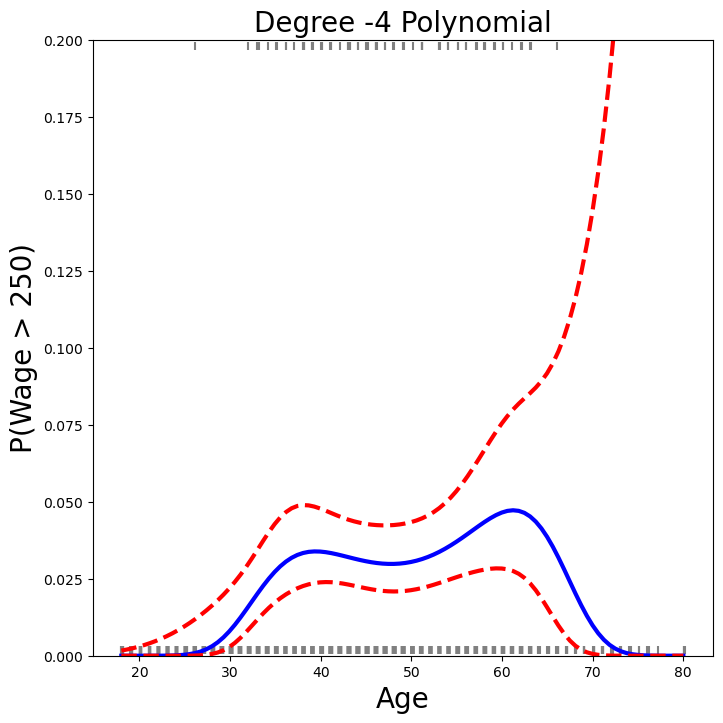

In [21]:
fig , ax = subplots(figsize =(8 ,8))
rng = np.random.default_rng (0)
ax.scatter(age + 0.2 * rng.uniform(size=y.shape [0]) , np.where(high_earn , 0.198 , 0.002) , fc='gray', marker='|')
for val , ls in zip([ preds.predicted_mean , bands [:,0], bands [:,1]], ['b','r--','r--']):
    ax.plot(age_df.values , val , ls , linewidth =3)
ax.set_title('Degree -4 Polynomial', fontsize =20)
ax.set_xlabel('Age', fontsize =20)
ax.set_ylim ([0 ,0.2])
ax.set_ylabel('P(Wage > 250)', fontsize =20)

## 1. fig, ax = subplots(figsize=(8, 8))

### What it does:
Creates a new matplotlib figure and axis object with a size of 8x8 inches using `matplotlib.pyplot.subplots()`.

### Why:
Initializes the canvas for plotting the logistic regression results, including the fitted probability curve, confidence bands, and observed data.

## 2. rng = np.random.default_rng(0)

### What it does:
Creates a NumPy random number generator (rng) with a fixed seed (0) for reproducibility.
This will be used to generate random noise for jittering the age values in the scatter plot.

### Why:
The fixed seed ensures that the random noise is the same every time the code is run, making the plot reproducible.
Jittering (adding small random noise) prevents overlapping points in the scatter plot, as explained in the rug plot description.

## 3. ax.scatter(age + 0.2 * rng.uniform(size=y.shape[0]), np.where(high_earn, 0.198, 0.002), fc='gray', marker='|')

### What it does:
Creates a scatter plot (rug plot) of the observed data, showing the age values and whether each observation is a high earner (wage > 250).

#### X-axis: age + 0.2 * rng.uniform(size=y.shape[0])
- `age` is the `Wage['age']` Series (the original age values).
- `rng.uniform(size=y.shape[0])` generates an array of random values between 0 and 1, with length equal to the number of observations (`y.shape[0]`, ~3000).
- `0.2 * rng.uniform(...)` scales the random values to a small range (±0.2 years) and adds them to age to jitter the points, preventing overlap for observations with the same age.

#### Y-axis: np.where(high_earn, 0.198, 0.002)
- `high_earn` is the binary Series (`y > 250`, where `y = Wage['wage']`), indicating whether wage > 250 (True/False).
- `np.where(high_earn, 0.198, 0.002)` assigns y = 0.198 for high earners (`high_earn = True`) and y = 0.002 for non-high earners (`high_earn = False`).
- These values place high earners near the top of the plot (y ≈ 0.2) and non-high earners near the bottom (y ≈ 0).

#### Other parameters:
- `fc='gray'`: Sets the face color of the markers to gray.
- `marker='|'`: Uses a vertical bar (|) as the marker shape, typical for rug plots.

### Why:
This creates a rug plot, where observations are plotted as vertical bars at the top (high earners, wage > 250) or bottom (non-high earners, wage ≤ 250) of the plot, with age on the x-axis.

**Jittering**: Adding small random noise (±0.2) to age prevents overlapping points for observations with the same age, making the density of observations visible (e.g., many individuals may have the same integer age like 30).

**Y-position choice**: Placing high earners at y = 0.198 and non-high earners at y = 0.002 visually separates the two groups within the plot's y-range (0 to 0.2), making it clear which observations are high earners without cluttering the probability curve.

## 4. for val, ls in zip([preds.predicted_mean, bands[:,0], bands[:,1]], ['b', 'r--', 'r--']):

### What it does:
Sets up a loop to plot three lines: the predicted log-odds and the 95% confidence interval bounds.

- `preds.predicted_mean`: The predicted log-odds from the logistic regression model (B) for the grid of age values (from `preds = B.get_prediction(newX)`).
- `bands[:,0]` and `bands[:,1]`: The lower and upper bounds of the 95% confidence intervals for the log-odds (from `bands = preds.conf_int(alpha=0.05)`).
- `['b', 'r--', 'r--']`: Line styles—solid blue ('b') for the predicted mean, dashed red ('r--') for the confidence bounds.
- `zip()` pairs each array (predicted_mean, lower bound, upper bound) with its corresponding line style.

### Why:
This prepares to plot the fitted logistic regression model (predicted log-odds) and its confidence bands, showing the estimated relationship and uncertainty.

## 5. ax.plot(age_df.values, val, ls, linewidth=3)

### What it does:
Plots a line on the axis:
- `age_df.values`: The x-values (100 evenly spaced age values from age_df, created via `age_grid = np.linspace(age.min(), age.max(), 100)`).
- `val`: The y-values (either `preds.predicted_mean`, `bands[:,0]`, or `bands[:,1]`), representing the log-odds.
- `ls`: The line style ('b' for the mean, 'r--' for the bounds).
- `linewidth=3`: Sets the line thickness to 3 for visibility.

### Why:
This plots the fitted logistic regression curve (blue solid line) and its 95% confidence bands (red dashed lines) over the range of age values.

**Note**: The y-values are log-odds, not probabilities. To plot probabilities (as implied by the y-axis label P(Wage > 250)), you would need to transform the log-odds using the logistic function:

```
P = 1/(1 + e^(-logit))
```

The lab's y-axis label suggests this transformation is either applied implicitly or intended for interpretation.

## 6. ax.set_title('Degree-4 Polynomial', fontsize=20)

### What it does:
Sets the plot title to 'Degree-4 Polynomial' with a font size of 20.

### Why:
Indicates that the plot shows the fit of a 4th-degree polynomial logistic regression model.

## 7. ax.set_xlabel('Age', fontsize=20)

### What it does:
Labels the x-axis as 'Age' with a font size of 20.

### Why:
Clearly identifies the x-axis variable (age).

## 8. ax.set_ylim([0, 0.2])

### What it does:
Sets the y-axis limits to range from 0 to 0.2.

### Why:
The y-axis is intended to represent probabilities (P(Wage > 250)), which range from 0 to 1, but the limit [0, 0.2] is chosen because the probabilities of wage > 250 are likely low (few high earners in the dataset), so zooming in on this range makes the plot clearer.

The rug plot's y-values (0.002 and 0.198) fit within this range, ensuring the scatter points are visible at the bottom and top.

## 9. ax.set_ylabel('P(Wage > 250)', fontsize=20)

### What it does:
Labels the y-axis as 'P(Wage > 250)' with a font size of 20.

### Why:
Indicates that the y-axis represents the probability of earning more than $250,000, aligning with the logistic regression model's output (though the plotted values are log-odds unless transformed).

In [22]:
cut_age = pd.qcut(age , 4)
summarize(sm.OLS(y, pd.get_dummies(cut_age)).fit())

,coef,std err,t,P>|t|
"(17.999, 33.75]",94.1584,1.478,63.692,0.0
"(33.75, 42.0]",116.6608,1.470,79.385,0.0
"(42.0, 51.0]",119.1887,1.416,84.147,0.0
"(51.0, 80.0]",116.5717,1.559,74.751,0.0


## Step Function (Piecewise Constant Function) Code Explanation

Fitting a step function (also called a piecewise constant function) to model the relationship between age and wage in the Wage dataset.

## 1. cut_age = pd.qcut(age, 4)

### What it does:
- Uses `pd.qcut` (quantile-based cut) to discretize the continuous age variable (`Wage['age']`) into 4 equal-sized bins based on quantiles.
- `qcut` divides the data such that each bin contains approximately the same number of observations (quartiles in this case: 25%, 50%, 75% quantiles).
- The resulting `cut_age` is a pandas Series of ordered categorical values, with labels representing the intervals:
  - `(17.999, 33.75]` (ages up to 33.75, the 25th percentile).
  - `(33.75, 42.0]` (ages from 33.75 to 42, the 50th percentile).
  - `(42.0, 51.0]` (ages from 42 to 51, the 75th percentile).
  - `(51.0, 80.0]` (ages above 51, up to the maximum age).
- Each observation in age is assigned to one of these bins.

### Why:
- A step function models wage as constant within each age bin, assuming that wage is roughly similar for individuals within the same age range.
- Using quantiles ensures each bin has an equal number of observations (~750 if the dataset has ~3000 rows), balancing the sample size across bins.
- This is simpler than polynomial regression, as it doesn't assume a smooth functional form, only that wage is constant within each bin.

### Details:
- The cutpoints (33.75, 42.0, 51.0) are automatically determined as the 25th, 50th, and 75th percentiles of age.
- The intervals are half-open: e.g., `(17.999, 33.75]` includes ages >17.999 and ≤33.75.
- `pd.qcut` returns an ordered categorical variable, preserving the order of bins (younger to older).

## 2. pd.get_dummies(cut_age)

### What it does:
- Converts the categorical `cut_age` Series into a matrix of dummy variables.
- Each bin becomes a column, with a value of 1 if the observation falls in that bin and 0 otherwise.
- Since `cut_age` has 4 categories, `pd.get_dummies(cut_age)` creates a matrix with 4 columns, one for each bin:
  - `(17.999, 33.75]`
  - `(33.75, 42.0]`
  - `(42.0, 51.0]`
  - `(51.0, 80.0]`
- Unlike the default behavior in some regression frameworks (which drop one category to avoid multicollinearity), `pd.get_dummies()` includes all 4 columns.

### Why:
- Dummy variables allow the categorical `cut_age` to be used in a linear regression model, where each bin's effect on wage is represented by a separate coefficient.
- Including all 4 columns means the model has no intercept (to avoid multicollinearity), and each coefficient directly represents the mean wage for that bin.

## 3. sm.OLS(y, pd.get_dummies(cut_age)).fit()

### What it does:
- Fits an Ordinary Least Squares (OLS) regression model using statsmodels.
- `y` is the response variable (`Wage['wage']`).
- `pd.get_dummies(cut_age)` is the design matrix with 4 columns (one for each age bin).
- The model is:

```
wage = β₁ · I(age ∈ (17.999, 33.75]) + β₂ · I(age ∈ (33.75, 42.0]) + β₃ · I(age ∈ (42.0, 51.0]) + β₄ · I(age ∈ (51.0, 80.0]) + ε
```

where `I(·)` is an indicator function (1 if the condition is true, 0 otherwise), and `βᵢ` is the mean wage for the i-th bin.

- `.fit()` estimates the coefficients `β₁, β₂, β₃, β₄`.

### Why:
- This fits the step function, where wage is modeled as constant within each age bin. The coefficients are the average wage values for each bin.
- The lack of an intercept (implicitly, since all dummy columns are included) ensures each coefficient directly represents the mean wage for its bin.

## 4. summarize(sm.OLS(y, pd.get_dummies(cut_age)).fit())

### What it does:
- Displays a summary of the fitted OLS model, showing:
  - **coef**: The estimated coefficient for each bin (mean wage).
  - **std err**: Standard error of each coefficient.
  - **t**: t-statistic for testing whether each coefficient is zero.
  - **P>|t|**: p-value for each t-test.

### Why:
- Provides the estimated mean wage for each age bin and assesses whether they are significantly different from zero (though this is less relevant here, as the focus is on the coefficients as group means).

## Model Results Interpretation

### Coefficients:
- `(17.999, 33.75]`: Mean wage = $94,158.40 for ages ≤33.75.
- `(33.75, 42.0]`: Mean wage = $116,660.80 for ages 33.75–42.
- `(42.0, 51.0]`: Mean wage = $119,188.70 for ages 42–51.
- `(51.0, 80.0]`: Mean wage = $116,571.70 for ages >51.

These coefficients are the average wage for each age bin, as the model uses all dummy variables without an intercept.

### Standard Errors:
Small (1.416–1.559), indicating precise estimates of the mean wage for each bin, due to the large sample size (~750 observations per bin).

### t-statistics and p-values:
All p-values are 0.0, indicating that each bin's mean wage is significantly different from zero. This is expected, as wages are positive, but the test is less relevant here since the goal is to estimate group means, not test if they're zero.

### Interpretation:
- Wages are lowest for the youngest group (≤33.75 years), peak in the 42–51 age range, and slightly decline for the oldest group (>51).
- The step function captures a simple, piecewise-constant relationship between age and wage, unlike the smooth polynomial curves used earlier.

## Splines

In [ ]:
bs_ = BSpline(internal_knots =[25 ,40 ,60] , intercept=True).fit(age)
bs_age = bs_.transform(age)
bs_age.shape

(3000, 7)

In [24]:
bs_age.head()

,"BSpline(intercept=True, internal_knots=[25, 40, 60], lower_bound=18.0,\n upper_bound=80.0)[0]","BSpline(intercept=True, internal_knots=[25, 40, 60], lower_bound=18.0,\n upper_bound=80.0)[1]","BSpline(intercept=True, internal_knots=[25, 40, 60], lower_bound=18.0,\n upper_bound=80.0)[2]","BSpline(intercept=True, internal_knots=[25, 40, 60], lower_bound=18.0,\n upper_bound=80.0)[3]","BSpline(intercept=True, internal_knots=[25, 40, 60], lower_bound=18.0,\n upper_bound=80.0)[4]","BSpline(intercept=True, internal_knots=[25, 40, 60], lower_bound=18.0,\n upper_bound=80.0)[5]","BSpline(intercept=True, internal_knots=[25, 40, 60], lower_bound=18.0,\n upper_bound=80.0)[6]"
0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
1,0.002915,0.559911,0.403778,0.033395,0.000000,0.000000,0.0
2,0.000000,0.000000,0.114796,0.618564,0.262733,0.003906,0.0
3,0.000000,0.000000,0.167109,0.633167,0.198880,0.000844,0.0
4,0.000000,0.000000,0.034014,0.508194,0.426542,0.031250,0.0



### Regression Splines:
These involve dividing the range of a predictor (e.g., age) into regions using knots and fitting a polynomial (usually cubic) in each region. The polynomials are constrained to join smoothly at the knots.

### Basis Functions:
Splines represent the non-linear relationship using a set of basis functions, which are combined to form the spline. The BSpline function in Python generates these basis functions.

### Cubic Splines:
By default, splines in this lab are cubic (degree 3), meaning each piece is a cubic polynomial, ensuring smoothness (continuous function and derivatives up to the second order at knots).

## 1. Creating the B-Spline Object

```python
bs_ = BSpline(internal_knots=[25, 40, 60], intercept=True).fit(age)
```

### What it does:
- **BSpline**: This is a class from the ISLP.transforms module (or possibly sklearn.preprocessing or patsy under the hood, as ISLP wraps these libraries). It constructs a B-spline basis for the input variable (age).
- **internal_knots=[25, 40, 60]**: Knots are specific points in the range of age where the spline's polynomial pieces connect. Here, the knots are at ages 25, 40, and 60. These divide the age range into four regions:
  - Below 25
  - 25 to 40
  - 40 to 60
  - Above 60
- **intercept=True**: This includes a constant term (intercept) in the basis, which is typical for regression models to allow the spline to shift vertically.
- **.fit(age)**: This method processes the input data (age, a Pandas Series or NumPy array of shape (3000,)) to set up the B-spline basis. It doesn't compute the regression coefficients yet; it just prepares the basis functions based on the knots and the range of age.

## 2. Transforming the Data

```python
bs_age = bs_.transform(age)
```

### What it does:
- **.transform(age)**: This converts the age variable into a matrix of basis functions. Each row corresponds to one observation (one age value), and each column represents the value of a specific B-spline basis function evaluated at that age.
- **What are basis functions?** For a cubic B-spline with 3 internal knots, the basis consists of a set of functions (typically 7 in this case, as we'll see below) that, when linearly combined, form the spline. Each basis function is non-zero only over a specific range of age, ensuring locality and smoothness.
- **Output (bs_age)**: This is a matrix where each row is an observation (one person's age) and each column is the value of one basis function for that age.

## 3. Checking the Shape

```python
bs_age.shape
# Output: (3000, 7)
```

### What it does:
- **bs_age.shape**: This returns the dimensions of the bs_age matrix.

### Why (3000, 7)?
- **Rows (3000)**: The Wage dataset has 3000 observations (workers), so there are 3000 rows, one for each age value.
- **Columns (7)**: The number of columns corresponds to the number of basis functions in the cubic B-spline. For a cubic spline (degree 3) with 3 internal knots, the number of basis functions is calculated as:

```
Number of basis functions = Number of internal knots + Degree + 1
```

Here:
- Internal knots = 3 (at 25, 40, 60)
- Degree = 3 (cubic spline, the default for BSpline)
- Add 1 for the intercept (since intercept=True)

```
3 + 3 + 1 = 7
```

Thus, the spline is represented by 7 basis functions, resulting in a matrix with 7 columns.

In [25]:
bs_age = MS([bs('age', internal_knots =[25 ,40 ,60]) ])
Xbs = bs_age.fit_transform(Wage)
M = sm.OLS(y, Xbs).fit()
summarize(M)

,coef,std err,t,P>|t|
intercept,60.4937,9.460,6.394,0.000
"bs(age, internal_knots=[25, 40, 60])[0]",3.9805,12.538,0.317,0.751
"bs(age, internal_knots=[25, 40, 60])[1]",44.6310,9.626,4.636,0.000
"bs(age, internal_knots=[25, 40, 60])[2]",62.8388,10.755,5.843,0.000
"bs(age, internal_knots=[25, 40, 60])[3]",55.9908,10.706,5.230,0.000
"bs(age, internal_knots=[25, 40, 60])[4]",50.6881,14.402,3.520,0.000
"bs(age, internal_knots=[25, 40, 60])[5]",16.6061,19.126,0.868,0.385



## 1. Creating the Spline Basis with MS and bs

```python
bs_age = MS([bs('age', internal_knots=[25, 40, 60])])
```

### What it does:
- **bs**: This is a function from ISLP.models (likely wrapping patsy or a similar library) that creates a B-spline basis for the age variable. It's similar to the BSpline class you used before but designed for integration with a model specification pipeline.
  - **internal_knots=[25, 40, 60]**: Specifies knots at ages 25, 40, and 60, dividing the age range into four regions.
  - By default, `bs()` uses a cubic spline (degree 3) and sets `intercept=False`, meaning it generates the spline basis without including a constant column (unlike `BSpline(intercept=True)` in your previous question).
- **MS**: This is the ModelSpec class from ISLP.models, which builds a model matrix (design matrix) for regression. It takes a list of transformations (here, `[bs(...)]`) and prepares them for fitting.
  - Wrapping `bs(...)` in `MS([...])` allows you to apply the spline transformation to the age column in the Wage DataFrame, integrating it into a formula-like framework (similar to `poly()` for polynomials in Section 7.8.1).

## 2. Transforming the Data

```python
Xbs = bs_age.fit_transform(Wage)
```

### What it does:
- **.fit_transform(Wage)**: This applies the spline transformation to the age column in the Wage DataFrame, producing a design matrix Xbs.
- **What is Xbs?** It's a matrix with:
  - Rows: 3000 (one for each observation in Wage).
  - Columns: 7 (1 for the intercept + 6 for the spline basis functions, as explained below).

### Why 7 columns?
- The `bs()` function generates a cubic spline basis with 3 internal knots. As discussed previously, a cubic spline (degree 3) with 3 knots typically produces 7 basis functions:

```
Number of basis functions = Internal knots + Degree + 1 = 3 + 3 + 1 = 7
```

- However, since `bs(intercept=False)` by default, it generates 6 basis functions (discarding one to avoid collinearity with the model's intercept).
- The ModelSpec or regression framework adds a separate intercept column, resulting in a 7-column matrix: 1 intercept + 6 spline basis functions.

## 3. Fitting the OLS Model

```python
M = sm.OLS(y, Xbs).fit()
```

### What it does:
- **sm.OLS**: This is from statsmodels.api, used to fit an Ordinary Least Squares (OLS) regression model.
  - **y**: The response variable (`Wage['wage']`, a Series of 3000 wage values).
  - **Xbs**: The design matrix with 3000 rows and 7 columns (intercept + 6 spline basis functions).
- **.fit()**: Estimates the regression coefficients by minimizing the sum of squared residuals.

### Model:
The model is:

```
wage = β₀ + β₁B₁(age) + β₂B₂(age) + ⋯ + β₆B₆(age) + ε
```

where:
- `β₀` is the intercept.
- `Bᵢ(age)` are the 6 B-spline basis functions (columns of Xbs).
- `β₁, …, β₆` are their coefficients.
- `ε` is the error term.

## Natural Spline

In [26]:
ns_age = MS([ns('age', df=5)]).fit(Wage)
M_ns = sm.OLS(y, ns_age.transform(Wage)).fit()
summarize(M_ns)

,coef,std err,t,P>|t|
intercept,60.4752,4.708,12.844,0.000
"ns(age, df=5)[0]",61.5267,4.709,13.065,0.000
"ns(age, df=5)[1]",55.6912,5.717,9.741,0.000
"ns(age, df=5)[2]",46.8184,4.948,9.463,0.000
"ns(age, df=5)[3]",83.2036,11.918,6.982,0.000
"ns(age, df=5)[4]",6.8770,9.484,0.725,0.468


<Axes: title={'center': 'Natural spline  df=5'}, xlabel='Age', ylabel='Wage '>

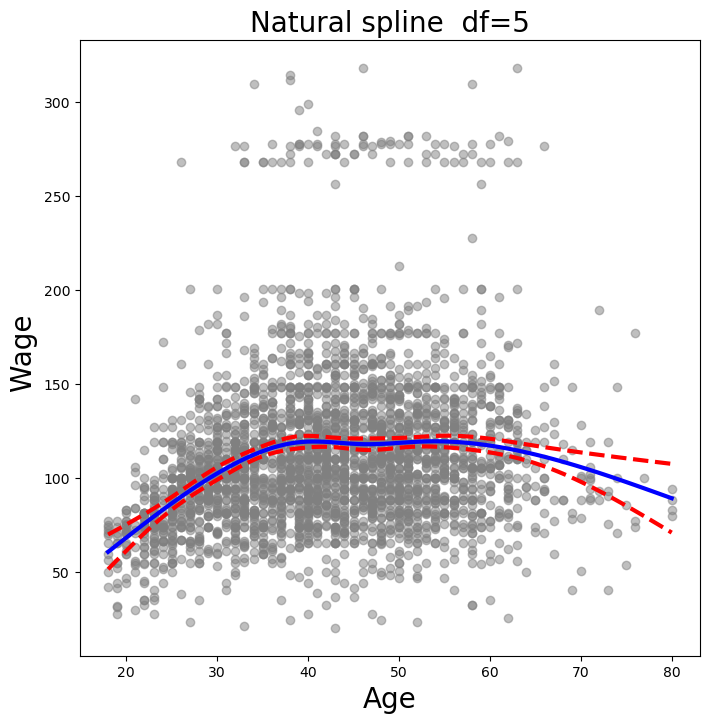

In [28]:
plot_wage_fit(age_df , ns_age , 'Natural spline  df=5')

## Natural Splines

Natural splines are a special type of cubic spline with additional constraints: they are linear (not cubic) beyond the boundary knots (the minimum and maximum values of the predictor, age in this case). This reduces overfitting at the edges of the data, where cubic splines can exhibit erratic behavior (e.g., sharp curves due to high-degree polynomials).

### Why Natural Splines?

They provide a smoother, more stable fit at the boundaries, making them suitable for datasets like Wage, where extreme ages (very young or old) may have fewer observations.

### Degrees of Freedom (df)

The df parameter controls the flexibility of the spline. For a natural spline, df equals the number of basis functions (including the intercept, unless specified otherwise). Here, df=5 means 5 basis functions (4 spline terms + 1 intercept in the regression model).

## Smoothing Splines and GAMs

In Chapter 7, you're learning about non-linear regression techniques. You've covered polynomial regression, step functions (Section 7.8.1), cubic splines, and natural splines (Section 7.8.2). Now, Section 7.8.3 introduces smoothing splines and Generalized Additive Models (GAMs):

### Smoothing Splines

A smoothing spline is a type of spline that fits a smooth curve to the data by minimizing a combination of squared-error loss and a penalty on the curve's roughness (controlled by a penalty parameter, λ). It's more flexible than cubic or natural splines because it uses a knot at every data point but controls overfitting via the penalty.

### GAMs

Generalized Additive Models extend linear models by allowing non-linear relationships between predictors and the response. A smoothing spline is a special case of a GAM with a single predictor and squared-error loss.

### Dataset

You're working with the Wage dataset (`Wage = load_data('Wage')`), modeling wage (response, `y = Wage['wage']`) as a function of age (predictor, `age = Wage['age']`), which has 3000 observations.



## Goal

Fit a smoothing spline to capture the non-linear relationship between age and wage using the pygam package.

In [30]:
X_age = np.asarray(age).reshape ((-1,1))
gam = LinearGAM(s_gam(0, lam =0.6))
gam.fit(X_age , y)

LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, scale=None, terms=s(0) + intercept, tol=0.0001, 
   verbose=False)

## 1. Preparing the Feature Matrix

```python
X_age = np.asarray(age).reshape((-1, 1))
```

- **`age`**: The predictor variable, a Pandas Series or NumPy array of 3000 age values from the Wage dataset.
- **`np.asarray(age)`**: Converts age to a NumPy array (if it isn’t already), ensuring compatibility with `pygam`.
- **`.reshape((-1, 1))`**: Reshapes the 1D array (shape `(3000,)`) into a 2D matrix (shape `(3000, 1)`).

**Why?** The `pygam` library expects a feature matrix (2D array), even for a single predictor, as GAMs are designed to handle multiple predictors.

- `-1`: Instructs NumPy to infer the number of rows (3000, matching the length of age) based on the data.
- `1`: Specifies one column.

**Result**: `X_age` is a `(3000, 1)` matrix where each row is an age value.

---

## 2. Defining the GAM Model

```python
gam = LinearGAM(s(0, lam=0.6))
```

- **`LinearGAM`**: A class from the `pygam` package that fits a GAM with squared-error loss (suitable for continuous responses like wage).
- **`s(0, lam=0.6)`**: Specifies a smoothing spline term for the first column of the feature matrix (index 0, corresponding to age in `X_age`).

  - `s`: A `pygam` function defining a smoothing spline term.
  - `0`: Indicates the spline applies to the first column of `X_age` (here, the only column).
  - `lam=0.6`: The penalty parameter (λ) controls the trade-off between fit and smoothness:
    - Small λ: Less penalty on roughness, leading to a wiggly spline that closely fits the data.
    - Large λ: Stronger penalty, resulting in a smoother (less flexible) spline, approaching a linear fit.
    - `λ = 0.6`: A moderate value, balancing flexibility and smoothness (chosen by the lab for demonstration).

### Default Settings (from the output):

- `fit_intercept=True`: Includes an intercept term in the model.
- `terms=s(0) + intercept`: The model includes a smoothing spline for age plus a constant term.
- `callbacks=[Deviance(), Diffs()]`: Monitors model fitting (`deviance` measures fit quality, `diffs` checks convergence).
- `max_iter=100, tol=0.0001`: Controls the optimization process (maximum iterations and convergence tolerance).
- `verbose=False`: Suppresses detailed fitting output.

---

## 3. Fitting the Model

```python
gam.fit(X_age, y)
```

- **`gam.fit`**: Fits the GAM by minimizing a penalized least squares objective:

\[
\text{Loss} = \sum_{i=1}^{3000} (y_i - f(\text{age}_i))^2 + \lambda \int (f''(x))^2 dx
\]

- The first term measures the squared-error loss (how well the spline \( f(\text{age}) \) fits wage).
- The second term penalizes the second derivative’s magnitude, ensuring smoothness.

- `X_age`: The `(3000, 1)` feature matrix.
- `y`: The response variable (`Wage['wage']`, 3000 values).

**Result**: The fitted model (`gam`) estimates a smooth function \( f(\text{age}) \) that predicts wage.

---

## 4. Output Interpretation

The output describes the fitted `LinearGAM` object:

```python
LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True,
          max_iter=100, scale=None, terms=s(0) + intercept, tol=0.0001,
          verbose=False)
```

This confirms the model is a GAM with:

- A smoothing spline on the first feature (`s(0)`).
- An intercept.
- A penalty parameter `λ = 0.6`.

The output doesn’t show coefficients (unlike OLS models) because smoothing splines in `pygam` represent the fit as a **smooth function**, not a fixed set of basis function coefficients. The **effective degrees of freedom (edf)** or **predictions** are typically used to interpret the fit.


<>:10: SyntaxWarning: invalid escape sequence '\l'
<>:10: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_8266/499212775.py:10: SyntaxWarning: invalid escape sequence '\l'
  ax.legend(title='$\lambda$')


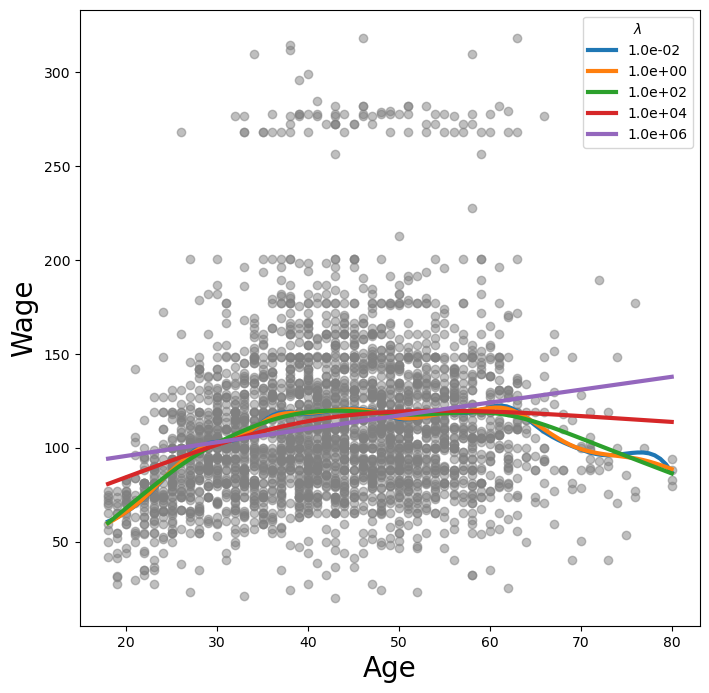

In [32]:
fig , ax = subplots(figsize =(8 ,8))
ax.scatter(age , y, facecolor='gray', alpha =0.5)
for lam in np.logspace (-2, 6, 5):
    gam = LinearGAM(s_gam(0, lam=lam)).fit(X_age , y)
    ax.plot(age_grid ,gam.predict(age_grid),
label='{:.1e}'.format(lam),
linewidth =3)
ax.set_xlabel('Age', fontsize =20)
ax.set_ylabel('Wage', fontsize =20)
ax.legend(title='$\lambda$')

  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00
 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


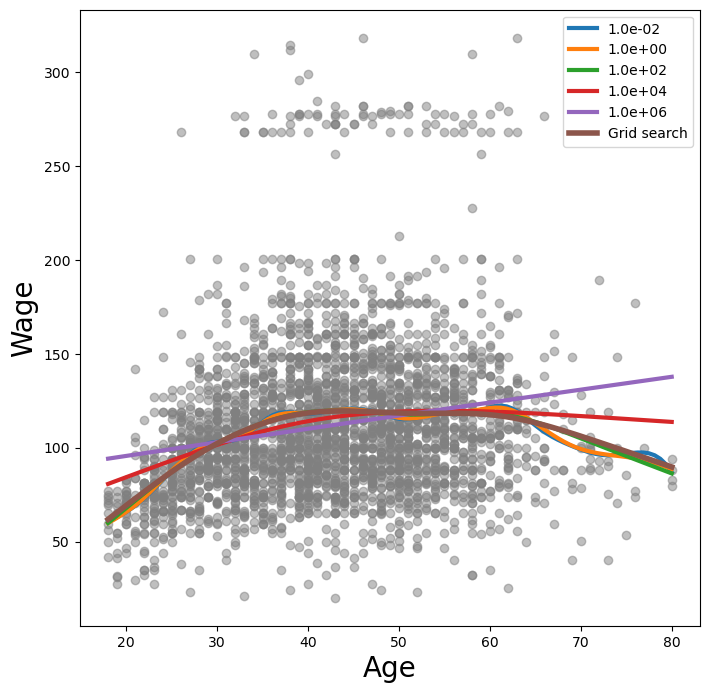

In [33]:
gam_opt = gam.gridsearch(X_age , y)
ax.plot(age_grid ,gam_opt.predict(age_grid),
label='Grid search',
linewidth =4)
ax.legend ()
fig

## 1. Setting Up the Plot

```python
fig, ax = subplots(figsize=(8, 8))
ax.scatter(age, y, facecolor='gray', alpha=0.5)
```

- `subplots(figsize=(8, 8))`: Creates a figure and axis object using `matplotlib.pyplot.subplots` with an 8x8-inch size for clear visualization.
- `ax.scatter(age, y, facecolor='gray', alpha=0.5)`: Plots a scatter plot of the raw data: age (x-axis) vs. wage (y-axis, `y = Wage['wage']`).
  - `facecolor='gray'`: Sets the color of the points.
  - `alpha=0.5`: Makes points semi-transparent to reduce overplotting, as the dataset has 3000 points.

---

## 2. Varying the Smoothing Parameter λ

```python
for lam in np.logspace(-2, 6, 5):
```

- `np.logspace(-2, 6, 5)`: Generates 5 values of λ evenly spaced on a logarithmic scale from \(10^{-2} = 0.01\) to \(10^6 = 1,000,000\).

The values are:
\[
\lambda = [10^{-2}, 10^{0}, 10^{2}, 10^{4}, 10^{6}] = [0.01, 1, 100, 10,000, 1,000,000]
\]

- Unlike `np.linspace` (linear spacing), `np.logspace` spaces points logarithmically, which is suitable for λ because its effect on smoothness is non-linear (small changes in small λ have larger impacts than in large λ).
- **Loop**: Iterates over these 5 λ values to fit and plot a smoothing spline for each.

---

## 3. Fitting the GAM for Each λ

```python
gam = LinearGAM(s(0, lam=lam)).fit(X_age, y)
```

- `LinearGAM(s(0, lam=lam))`: Creates a GAM with a smoothing spline term for the first column of `X_age` (the age variable).
- `s(0, lam=lam)`: Specifies a smoothing spline with the current λ value.
- `X_age`: A `(3000, 1)` matrix of age values (from your previous setup using `np.asarray(age).reshape((-1, 1))`).
- `.fit(X_age, y)`: Fits the GAM by minimizing the penalized least squares objective:

\[
\text{Loss} = \sum_{i=1}^{3000} (y_i - f(\text{age}_i))^2 + \lambda \int (f''(x))^2 dx
\]

- The first term ensures the spline fits the data.
- The λ term penalizes roughness (second derivative), with higher λ producing smoother curves.

**Result**: For each λ, a fitted GAM (`gam`) estimates a smooth function \(f(\text{age})\) for predicting wage.

---

## 4. Plotting the Fitted Splines

```python
ax.plot(age_grid, gam.predict(age_grid), label='{:.1e}'.format(lam), linewidth=3)
```

- `age_grid`: Not defined in the snippet but likely a 1D array of age values (e.g., `np.linspace(min(age), max(age), 100)`) for smooth plotting.  
  - Used to generate predictions over a fine grid of ages, ensuring a continuous curve.

- `gam.predict(age_grid)`: Computes predicted wage values for `age_grid` using the fitted GAM.  
  - `age_grid` must be reshaped to `(n, 1)` (where `n` is the number of grid points, e.g., 100) to match `pygam`’s 2D input requirement.

- `label='{:.1e}'.format(lam)`: Labels each curve with the λ value in scientific notation (e.g., `1.0e-02` for λ = 0.01).
- `linewidth=3`: Makes the curves thick for visibility.

**Result**: Plots a curve for each λ, showing how the predicted wage vs. age relationship changes with smoothness.

---

## 5. Adding Labels and Legend

```python
ax.set_xlabel('Age', fontsize=20)
ax.set_ylabel('Wage', fontsize=20)
ax.legend(title='$\\lambda$')
```

- **Labels**: Sets the x-axis label to “Age” and y-axis to “Wage” with large font size for readability.
- `ax.legend(title='$\\lambda$')`: Adds a legend to distinguish the curves, with λ rendered using LaTeX.

---

## Expected Plot

The plot will show:

- **Scatter Plot**: Gray, semi-transparent points for the 3000 (age, wage) pairs.
- **Five Curves**: Each representing the fitted smoothing spline for a diffe


In [34]:
age_term = gam.terms [0]
lam_4 = approx_lam(X_age , age_term , 4)
age_term.lam = lam_4
degrees_of_freedom (X_age , age_term)

4.0000001000025565

## 1. Extracting the Smoothing Spline Term

```python
age_term = gam.terms[0]
```

- `gam`: The `LinearGAM` object from your previous setup, fitted with a smoothing spline (e.g., `LinearGAM(s(0, lam=0.6))` or from the λ loop).
- `gam.terms`: A list of terms in the GAM model. Here, it contains:
  - A smoothing spline term for age (`s(0)`).
  - An intercept term (since `fit_intercept=True`).

- `gam.terms[0]`: Selects the first term — the smoothing spline for age — a `pygam` term object containing details like the current λ, basis functions, and penalty structure.

**Purpose**: Isolates the smoothing spline term to modify its λ and compute its effective degrees of freedom (edf).

---

## 2. Finding λ for 4 Degrees of Freedom

```python
lam_4 = approx_lam(X_age, age_term, 4)
```

- `approx_lam`: A function from `ISLP.pygam` that estimates the smoothing parameter λ to achieve a **target effective degrees of freedom** (here, 4) for a given term and dataset.

### Arguments:

- `X_age`: The `(3000, 1)` feature matrix of age values, used to compute the spline’s basis and penalty matrices.
- `age_term`: The smoothing spline term (`s(0)`) extracted from `gam.terms[0]`.
- `4`: The target effective degrees of freedom (`edf = 4`).

### How It Works:

In smoothing splines, `edf` depends on λ through the penalty term in the objective:

\[
\text{Loss} = \sum_{i=1}^{3000} (y_i - f(\text{age}_i))^2 + \lambda \int (f''(x))^2 dx
\]

- The `edf` is computed from the trace of the smoothing matrix (or hat matrix), which depends on λ.
  - Smaller λ → increased edf (more flexible spline).
  - Larger λ → reduced edf (smoother spline).

- `approx_lam` **numerically searches** for a λ that yields an edf close to 4, taking into account:
  - The spline’s basis.
  - The distribution of data in `X_age`.

**Result**: `lam_4` is the estimated λ value (a scalar, e.g., 10, 100).

---

## 3. Updating the Smoothing Parameter

```python
age_term.lam = lam_4
```

- `age_term.lam`: The λ attribute of the smoothing spline term.
- **Assignment**: Updates the term’s λ to `lam_4`.

**Purpose**: Ensures the smoothing spline term reflects the λ that corresponds to `edf ≈ 4`, so all future calculations (e.g., predictions or edf checks) use this updated setting.

---

## 4. Verifying the Degrees of Freedom

```python
degrees_of_freedom(X_age, age_term)
```

- `degrees_of_freedom`: A function from `ISLP.pygam` that computes the effective degrees of freedom for a given term and dataset.

### Arguments:

- `X_age`: The `(3000, 1)` matrix of age values.
- `age_term`: The smoothing spline term with updated λ (`lam_4`).

### Output:

```
4.000000100004728
```

- Confirms that the **edf is approximately 4**, as targeted.
- The small deviation (`4.000000100004728`) is due to numerical precision.

---

## Note on edf

The **effective degrees of freedom (edf)** includes:

- 1 df from the **intercept**.
- 1 df from the **linear component** of the smoothing spline (which isn't penalized).
- ~2 df from the **non-linear part** of the spline.

**Total edf ≈ 4**, matching the goal set in `approx_lam`.



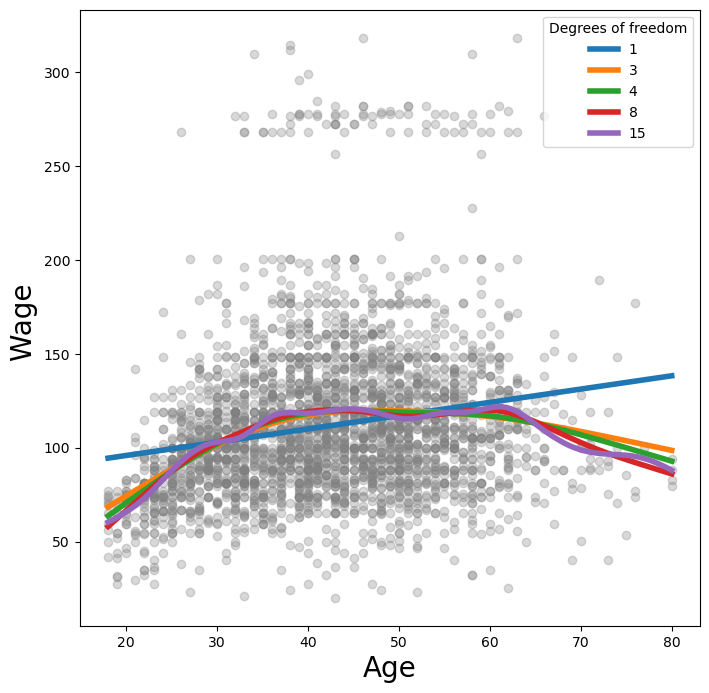

In [35]:
fig , ax = subplots(figsize =(8 ,8))
ax.scatter(X_age , y,facecolor='gray', alpha =0.3)
for df in [1 ,3 ,4 ,8 ,15]:
    lam = approx_lam(X_age , age_term , df+1)
    age_term.lam = lam
    gam.fit(X_age , y)
    ax.plot(age_grid ,
gam.predict(age_grid),
label='{:d}'.format(df),
linewidth =4)
ax.set_xlabel('Age', fontsize =20)
ax.set_ylabel('Wage ', fontsize =20)
ax.legend(title='Degrees of freedom')

## 1. Setting Up the Plot

```python
fig, ax = subplots(figsize=(8, 8))
ax.scatter(X_age, y, facecolor='gray', alpha=0.3)
```

- `subplots(figsize=(8, 8))`: Creates a figure and axis object using `matplotlib.pyplot.subplots` with an 8x8-inch size for clear visualization.
- `ax.scatter(X_age, y, facecolor='gray', alpha=0.3)`: Plots a scatter plot of the raw data:
  - `X_age`: A `(3000, 1)` matrix of age values.
  - `y`: Wage values.
  - `facecolor='gray'`: Sets the point color.
  - `alpha=0.3`: Makes points semi-transparent to reduce overplotting.

---

## 2. Varying the Degrees of Freedom

```python
for df in [1, 3, 4, 8, 15]:
```

- Iterates over a list of target degrees of freedom (`df`) for the smoothing spline **excluding** the intercept.
- **Why `df + 1`?**
  - In `LinearGAM(fit_intercept=True)`, the model includes:
    - An intercept (1 df).
    - An unpenalized linear term in the spline (1 df).
  - So, to get a total edf of `df + 1`, we must add 1 to account for the intercept and linear term.
  - Target `edf` values:
    \[
    [1+1, 3+1, 4+1, 8+1, 15+1] = [2, 4, 5, 9, 16]
    \]

---

## 3. Finding λ for Each edf

```python
lam = approx_lam(X_age, age_term, df+1)
age_term.lam = lam
```

- `approx_lam(X_age, age_term, df+1)`:
  - From `ISLP.pygam`.
  - Estimates the smoothing parameter `λ` that gives an edf ≈ `df+1`.
- Arguments:
  - `X_age`: The `(3000, 1)` matrix of age values.
  - `age_term`: The smoothing spline term (`s(0)`).
  - `df + 1`: The desired effective degrees of freedom.
- `age_term.lam = lam`: Updates the spline term’s smoothing parameter so the next model fit reflects the new λ.

---

## 4. Fitting the GAM

```python
gam.fit(X_age, y)
```

- `gam`: The `LinearGAM` object (e.g., `LinearGAM(s(0, lam=...))`).
- `.fit(X_age, y)`: Fits the GAM using the updated `λ`.

Objective minimized:

\[
\text{Loss} = \sum_{i=1}^{3000} (y_i - f(\text{age}_i))^2 + \lambda \int (f''(x))^2 dx
\]

- Produces a smoothing spline with `edf ≈ df + 1`.

---

## 5. Plotting the Fitted Splines

```python
ax.plot(age_grid, gam.predict(age_grid), label='{:d}'.format(df), linewidth=4)
```

- `age_grid`: A 1D array of evenly spaced age values (e.g., `np.linspace(min(age), max(age), 100)`).
- `gam.predict(age_grid)`: Predicts wage for each age in `age_grid`.
- `label='{:d}'.format(df)`: Labels each curve with its `df` value.
- `linewidth=4`: Thick lines for better visibility.

---

## 6. Adding Labels and Legend

```python
ax.set_xlabel('Age', fontsize=20)
ax.set_ylabel('Wage', fontsize=20)
ax.legend(title='Degrees of freedom')
```

- Adds axis labels with large font sizes.
- Adds a legend titled “Degrees of freedom” to distinguish spline curves by `df`.

---

## Expected Plot

The plot will show:

- **Scatter Plot**: Gray, semi-transparent points for the 3000 `(age, wage)` pairs.
- **Five Spline Curves** with `edf ≈ 2, 4, 5, 9, 16`, corresponding to:
  - `df = 1`: `edf = 2` → Linear fit (intercept + linear term).
  - `df = 3`: `edf = 4` → Moderately smooth.
  - `df = 4`: `edf = 5` → More flexible than df=3.
  - `df = 8`: `edf = 9` → Captures finer variations.
  - `df = 15`: `edf = 16` → Very wiggly, closely fitting the data (risk of overfitting).

- **Legend**: Labels each curve with its `df` value (1, 3, 4, 8, 15).

---

## Why `df + 1`?

- **Intercept**: The GAM includes an intercept (1 df).
- **Linear Term**: The smoothing spline includes a linear component (1 df), which is not penalized.
- Therefore, to get `edf ≈ df + 1`, we must add 1 to the desired df.

**Example**:
- `df = 1` → Target `edf = 2` → Linear fit (intercept + slope).


## Additive Models with Several Terms


This section demonstrates fitting a generalized additive model (GAM) "by hand" using natural splines for `age` and `year`, and dummy variables for the categorical variable `education`. The goal is to predict `wage` with a flexible model that allows nonlinear relationships for continuous predictors (`age`, `year`) and incorporates the categorical predictor (`education`).

In [37]:
ns_age = NaturalSpline(df=4).fit(age)
ns_year = NaturalSpline(df=5).fit(Wage['year'])
Xs = [ns_age.transform(age),
ns_year.transform(Wage['year']),
pd.get_dummies(Wage['education']).values]
X_bh = np.hstack(Xs)
gam_bh = sm.OLS(y, X_bh).fit()



### Step-by-step Breakdown

```python
ns_age = NaturalSpline(df=4).fit(age)
```

- `NaturalSpline`: A class from `ISLP.transforms` that creates a natural cubic spline basis for a given variable.
- `df=4`: Specifies 4 degrees of freedom (i.e., 4 basis functions). More degrees = more flexibility.
- `.fit(age)`: Fits the spline to the `age` variable, learning the appropriate knot locations from the data.
- `ns_age`: A fitted `NaturalSpline` object that can transform `age` into a matrix of spline basis functions.

---

```python
ns_year = NaturalSpline(df=5).fit(Wage['year'])
```

- Creates a natural spline for the `year` variable with 5 degrees of freedom.
- `Wage['year']`: A pandas Series containing the year (e.g., 2003, 2004...).
- `.fit(...)`: Fits the spline to the year data.

---

```python
Xs = [
    ns_age.transform(age),
    ns_year.transform(Wage['year']),
    pd.get_dummies(Wage['education']).values
]
```

- `Xs`: A list of 3 components for building the model matrix:
  1. `ns_age.transform(age)`: Transforms `age` into a matrix of shape `(n_samples × 4)`.
  2. `ns_year.transform(Wage['year'])`: Transforms `year` into a matrix of shape `(n_samples × 5)`.
  3. `pd.get_dummies(Wage['education']).values`: Converts categorical `education` to dummy variables:
     - If `education` has 5 categories, this results in a matrix of shape `(n_samples × 5)`.
     - `.values`: Converts the DataFrame to a NumPy array.

---

```python
X_bh = np.hstack(Xs)
```

- `np.hstack(...)`: Horizontally stacks the 3 matrices into a single model matrix `X_bh`.
- If age has 4 basis functions, year has 5, and education has 5 levels, the resulting shape is:
  \[
  \text{X\_bh} \in \mathbb{R}^{n\_samples \times (4 + 5 + 5)} = \mathbb{R}^{n \times 14}
  \]

- The matrix combines:
  - Nonlinear effects of age (via splines),
  - Nonlinear effects of year (via splines),
  - Categorical effects of education (via dummy encoding).

---

```python
gam_bh = sm.OLS(y, X_bh).fit()
```

- Fits an **Ordinary Least Squares (OLS)** regression using `statsmodels.api.OLS`.
- `y`: The response variable (`wage`).
- `X_bh`: The full model matrix with splines and dummies.
- `.fit()`: Estimates regression coefficients by minimizing squared residuals.

**Result**: `gam_bh` is a fitted OLS model object, which acts as our hand-built GAM.



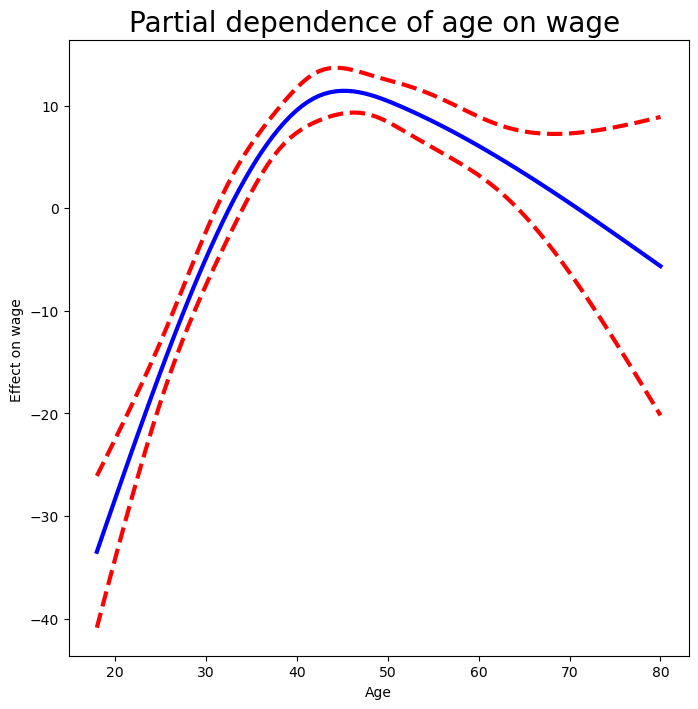

In [39]:
age_grid = np.linspace(age.min(),
age.max(),
100)
X_age_bh = X_bh.copy () [:100]
X_age_bh [:] = X_bh [:]. mean (0)[None ,:]
X_age_bh [: ,:4] = ns_age.transform(age_grid)
preds = gam_bh.get_prediction(X_age_bh)
bounds_age = preds.conf_int(alpha =0.05)
partial_age = preds.predicted_mean
center = partial_age.mean ()
partial_age -= center
bounds_age -= center
fig , ax = subplots(figsize =(8 ,8))
ax.plot(age_grid , partial_age , 'b', linewidth =3)
ax.plot(age_grid , bounds_age [:,0], 'r--', linewidth =3)
ax.plot(age_grid , bounds_age [:,1], 'r--', linewidth =3)
ax.set_xlabel('Age')
ax.set_ylabel('Effect on wage ')
ax.set_title('Partial dependence of age on wage ', fontsize =20);

## Step-by-Step Breakdown: Partial Dependence for Age in a GAM

---

### 1. Creating the Age Grid

```python
age_grid = np.linspace(age.min(), age.max(), 100)
```

- Creates a grid of 100 evenly spaced values between the minimum and maximum of the `age` variable.
- `age` is a pandas Series.
- `np.linspace(start, stop, num)` generates `num` points from `start` to `stop`, inclusive.
- Example: If `age.min() = 18` and `age.max() = 80`, then `age_grid = [18, 18.62, ..., 80]`.
- Used to evaluate partial dependence of wage on age.

---

### 2. Initializing a Prediction Matrix

```python
X_age_bh = X_bh.copy()[:100]
```

- Copies the original model matrix `X_bh`, which has shape `(n_samples, 14)`.
- Takes the first 100 rows for prediction over the age grid.
- Avoids altering the original data.

---

### 3. Holding All Other Predictors at Their Means

```python
X_age_bh[:] = X_bh[:].mean(0)[None, :]
```

- Computes column-wise means from `X_bh`.
- `[None, :]` reshapes means to `(1, 14)` so it can be broadcasted across all 100 rows.
- This sets all predictors (age, year, education) to their average values — important for isolating the effect of age.

---

### 4. Replacing the Age Spline Basis

```python
X_age_bh[:, :4] = ns_age.transform(age_grid)
```

- `ns_age`: A fitted `NaturalSpline(df=4)` object.
- `.transform(age_grid)` returns a `(100, 4)` matrix of spline basis functions evaluated at grid points.
- Replaces the first 4 columns of `X_age_bh` (age spline basis) with values from `age_grid`.

---

### 5. Making Predictions

```python
preds = gam_bh.get_prediction(X_age_bh)
```

- `gam_bh`: Fitted OLS GAM model.
- `get_prediction(...)` returns predictions and confidence intervals for new input data.
- All predictors except age are held constant, isolating the effect of age.

---

### 6. Computing Confidence Bounds

```python
bounds_age = preds.conf_int(alpha=0.05)
```

- Computes 95% confidence intervals.
- Returns a `(100, 2)` array:
  - Column 0: Lower bounds.
  - Column 1: Upper bounds.

---

### 7. Extracting and Centering the Effect

```python
partial_age = preds.predicted_mean
center = partial_age.mean()
partial_age -= center
bounds_age -= center
```

- `partial_age`: The predicted mean wage values for each age in the grid.
- Centering the effect (subtracting the mean) removes the constant offset due to other variables.
- `bounds_age` is adjusted accordingly.

---

### 8. Plotting the Partial Dependence

```python
fig, ax = subplots(figsize=(8, 8))
ax.plot(age_grid, partial_age, 'b', linewidth=3)
ax.plot(age_grid, bounds_age[:, 0], 'r--', linewidth=3)
ax.plot(age_grid, bounds_age[:, 1], 'r--', linewidth=3)
ax.set_xlabel('Age')
ax.set_ylabel('Effect on wage')
ax.set_title('Partial dependence of age on wage', fontsize=20)
```

- Blue line: The centered partial effect of age on wage.
- Red dashed lines: Lower and upper 95% confidence bounds.
- Labels and title improve readability.

---

## Explanation of the Process (As Described in the Text)

1. **Grid Creation**  
   - `np.linspace(...)` creates 100 age values between `age.min()` and `age.max()`.
   - `X_age_bh = X_bh.copy()[:100]` initializes a new prediction matrix with matching shape.

2. **Fixing Other Variables**  
   - `X_age_bh[:] = X_bh[:].mean(0)[None, :]` sets all values in `X_age_bh` to the column-wise means of the original data.
   - This holds year and education constant, isolating age.

3. **Re-inserting Age Spline Terms**  
   - `X_age_bh[:, :4] = ns_age.transform(age_grid)` injects new values for age, allowing only it to vary across the grid.

---

## Key Concepts

### ✅ Partial Dependence Plot

- Shows the estimated function **f₁(age)** from the GAM.
- Reflects how wage changes with age **after averaging out** effects of year and education.

Mathematically:

```math
PD(x₁) = E_{x₂,...}[f₁(x₁) + f₂(x₂) + ...] = f₁(x₁) + constant
```

### ✅ Why Use Mean Values?

- Approximates the marginal effect of age across the distribution of other variables.
- A standard method in partial dependence plotting.

### ✅ Why Center the Plot?

- Removes the influence of the intercept and other predictors.
- Helps focus on the *relative* effect of age on wage.
- Y-axis becomes "Effect on wage" rather than "Wage".

### ✅ Confidence Intervals

- Shaded/red dashed bands reflect uncertainty in the age-wage relationship.
- Useful to assess statistical significance.

### ✅ Natural Spline Basis

- The first 4 columns of `X_bh` correspond to the spline basis functions for age.
- The GAM models wage as a linear combination of these basis functions, allowing nonlinear trends.



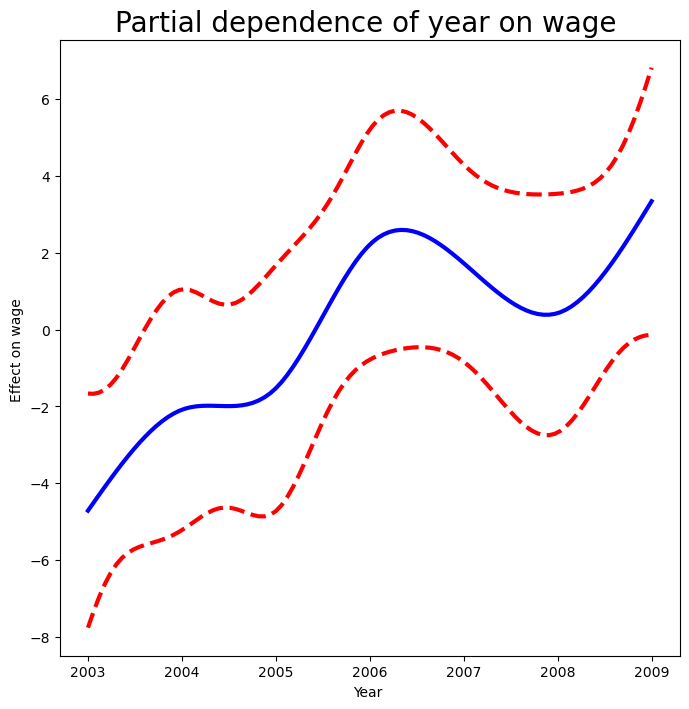

In [40]:
year_grid = np.linspace (2003 , 2009, 100)
year_grid = np.linspace(Wage['year'].min(),
Wage['year'].max(),
100)
X_year_bh = X_bh.copy () [:100]
X_year_bh [:] = X_bh [:]. mean (0)[None ,:]
X_year_bh [: ,4:9] = ns_year.transform(year_grid)
preds = gam_bh.get_prediction(X_year_bh)
bounds_year = preds.conf_int(alpha =0.05)
partial_year = preds.predicted_mean
center = partial_year.mean ()
partial_year -= center
bounds_year -= center
fig , ax = subplots(figsize =(8 ,8))
ax.plot(year_grid , partial_year , 'b', linewidth =3)
ax.plot(year_grid , bounds_year [:,0], 'r--', linewidth =3)
ax.plot(year_grid , bounds_year [:,1], 'r--', linewidth =3)
ax.set_xlabel('Year ')
ax.set_ylabel('Effect on wage ')
ax.set_title('Partial dependence of year on wage ', fontsize =20);

## Partial Dependence Plot for Year (GAM)

This section visualizes the effect of **year** on wage using a Generalized Additive Model (GAM), while holding other predictors (age and education) at their mean values.

---

### 🎯 GAM Model Structure

The GAM, previously fitted as `gam_bh` using `sm.OLS`, models wage as:

```math
\text{wage} = f_1(\text{age}) + f_2(\text{year}) + f_3(\text{education}) + \epsilon
```

- `f₁(age)`: Modeled using a natural spline with 4 degrees of freedom.
- `f₂(year)`: Natural spline with 5 degrees of freedom.
- `f₃(education)`: Dummy variables.
- The partial dependence plot focuses on `f₂(year)`.

---

### 🧮 Step-by-Step Code Explanation

#### 1. Create a Grid for Year

```python
year_grid = np.linspace(Wage['year'].min(), Wage['year'].max(), 100)
```

- `Wage['year']` is a pandas Series of years (e.g., 2003 to 2009).
- `np.linspace(...)` generates 100 evenly spaced values.
- This grid defines where we’ll evaluate the effect of year.

---

#### 2. Initialize the Prediction Matrix

```python
X_year_bh = X_bh.copy()[:100]
```

- `X_bh`: Model matrix with shape `(n_samples, 14)`.
- Copies and trims the matrix to 100 rows to match `year_grid`.

---

#### 3. Fix All Predictors to Their Means

```python
X_year_bh[:] = X_bh[:].mean(0)[None, :]
```

- Sets each row of `X_year_bh` to the mean values of the original predictors.
- Holds age and education constant, isolating the effect of year.

---

#### 4. Replace Year Spline Basis Columns

```python
X_year_bh[:, 4:9] = ns_year.transform(year_grid)
```

- `ns_year`: Fitted natural spline with `df=5`.
- `.transform(year_grid)` outputs a `(100, 5)` matrix.
- Replaces columns `4–8` with year spline basis functions.

---

#### 5. Make Predictions

```python
preds = gam_bh.get_prediction(X_year_bh)
```

- Predicts wage using the GAM model, varying only `year`.

---

#### 6. Compute and Center Confidence Intervals

```python
bounds_year = preds.conf_int(alpha=0.05)
partial_year = preds.predicted_mean
center = partial_year.mean()
partial_year -= center
bounds_year -= center
```

- `partial_year`: Estimated effect of year on wage.
- Centering removes the constant term (effect from fixed predictors).
- Confidence intervals are adjusted accordingly.

---

#### 7. Plot the Partial Dependence

```python
fig, ax = subplots(figsize=(8, 8))
ax.plot(year_grid, partial_year, 'b', linewidth=3)
ax.plot(year_grid, bounds_year[:, 0], 'r--', linewidth=3)
ax.plot(year_grid, bounds_year[:, 1], 'r--', linewidth=3)
ax.set_xlabel('Year')
ax.set_ylabel('Effect on wage')
ax.set_title('Partial dependence of year on wage', fontsize=20)
```

- **Blue line**: Centered partial effect of year.
- **Red dashed lines**: 95% confidence bounds.
- Axes labeled for interpretation.

---

### 🔍 Key Differences Compared to Age Plot

| Aspect         | Age Plot                      | Year Plot                    |
|----------------|-------------------------------|------------------------------|
| **Spline df**  | 4 (columns 0–3)               | 5 (columns 4–8)              |
| **Range**      | Typically 18 to 80            | Narrower, e.g., 2003–2009    |
| **Interpretation** | Career-related wage changes | Time trends (e.g., economy) |
| **Complexity** | Often nonlinear               | Smoother, less variance      |

---

### 💡 Summary

- This plot shows the partial effect of **year** on wage, isolating it from age and education.
- The method mirrors that used for age:
  - Create grid.
  - R


In [41]:
gam_full = LinearGAM(s_gam (0) + s_gam(1, n_splines =7) + f_gam(2, lam =0))
Xgam = np.column_stack ([age , Wage['year'], Wage['education'].cat.codes ])
gam_full = gam_full.fit(Xgam , y)

## Fitting a Full GAM Model Using `pygam`

This section shows how to fit a Generalized Additive Model (GAM) using the `pygam` library, incorporating:

- A **smoothing spline** for `age`
- A **smoothing spline** for `year`
- A **categorical** (factor) term for `education`

---

### 📌 Model Definition

```python
gam_full = LinearGAM(
    s_gam(0) +             # smoothing spline for age
    s_gam(1, n_splines=7) + # smoothing spline for year (7 unique values)
    f_gam(2, lam=0)         # categorical term for education
)
```

- `LinearGAM`: GAM model for continuous responses.
- `s_gam(0)`: Spline for the 1st predictor (age).
  - Uses default `n_splines=20` and `lam=0.6` for smoothness.
- `s_gam(1, n_splines=7)`: Spline for 2nd predictor (year).
  - Only 7 unique years, so we use 7 basis functions.
- `f_gam(2, lam=0)`: Categorical term for 3rd predictor (education).
  - `lam=0` disables smoothing — behaves like standard dummy variables.

---

### 🧱 Creating the Design Matrix

```python
Xgam = np.column_stack([
    age,                      # continuous
    Wage['year'],             # continuous (7 unique values)
    Wage['education'].cat.codes  # categorical encoded as integers
])
```

- `Wage['education'].cat.codes`: Converts categorical levels (e.g., "< HS Grad", "College") to integer codes (e.g., 0, 1, 2, ...).
- `np.column_stack`: Combines predictors into shape `(n_samples, 3)`.

---

### 🔧 Fitting the Model

```python
gam_full = gam_full.fit(Xgam, y)
```

- `Xgam`: Design matrix with 3 predictors.
- `y`: Target variable (e.g., `Wage['wage']`).
- Fits the GAM by optimizing both:
  - Coefficients
  - Smoothing parameters (λ for splines)

---

### 💡 Key Concepts

#### ✅ Smoothing Splines vs. Natural Splines

|                     | Natural Splines                    | Smoothing Splines                |
|---------------------|------------------------------------|----------------------------------|
| **Basis**           | Fixed number of basis functions    | Can use many basis functions     |
| **Behavior at edges**| Linear beyond boundary knots      | No constraint                    |
| **Flexibility control** | Controlled by `df`             | Controlled by `λ`                |
| **Penalty**         | None                               | Penalty on 2nd derivative        |

- **age**: Uses default `n_splines=20`, `lam=0.6`
- **year**: Uses `n_splines=7` to match 7 unique values

---

#### 🎓 Why `n_splines=7` for Year?

- The `year` variable has only 7 unique values (e.g., 2003–2009).
- Using 7 basis functions prevents overfitting and matches the granularity of the data.

---

#### 🏷️ Categorical Education with `f_gam`

- `f_gam(2, lam=0)`:
  - Handles education as a **categorical** variable.
  - `lam=0`: No smoothing, acts like dummy variables (each level has its own effect).
- `.cat.codes`: Converts category labels into integers.

---

#### 🧠 Simultaneous Fitting of Terms

- In GAMs, all terms are **fitted simultaneously**.
- This ensures partial effects like `f₁(age)` reflect **the effect of age after accounting for year and education**.
- Unlike linear regression with additive terms, splines adjust dynamically to improve overall model fit.

---

#### ⚙️ Why `.cat.codes` for Education?

- `pygam` requires **numeric inputs**.
- `.cat.codes` turns categories into integers (`0, 1, 2, ...`), which `f_gam` inter_


Text(0.5, 1.0, 'Partial dependence of age on wage - default lam =0.6 ')

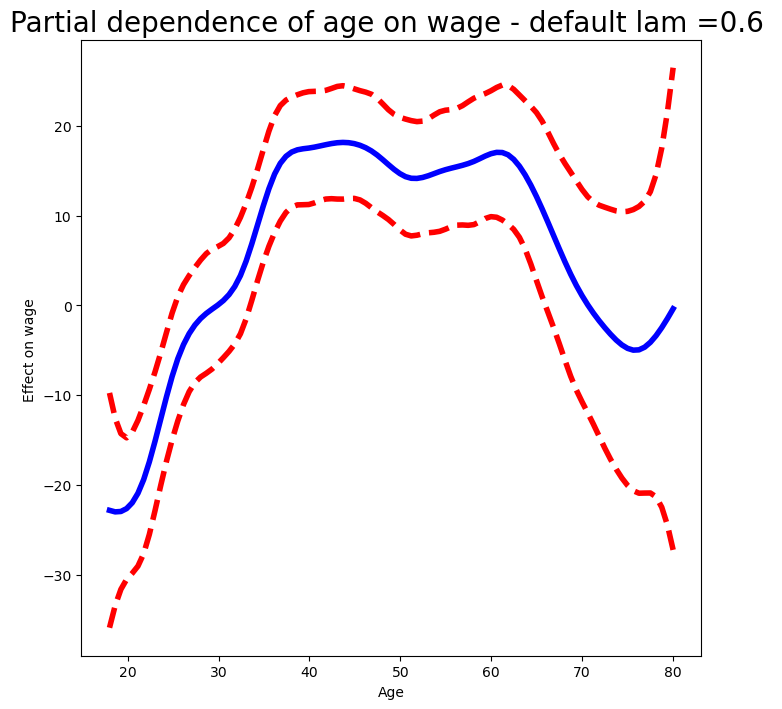

In [42]:
fig , ax = subplots(figsize =(8 ,8))
plot_gam(gam_full , 0, ax=ax)
ax.set_xlabel('Age')
ax.set_ylabel('Effect on wage ')
ax.set_title('Partial dependence of age on wage - default lam =0.6 ',
fontsize =20)

## 🎯 Visualizing the Partial Effect of Age Using `pygam.plot_gam`

The fitted GAM model:

```math
\text{wage} = f_1(\text{age}) + f_2(\text{year}) + f_3(\text{education}) + \epsilon
```

Where:
- **`f₁(age)`**: A smoothing spline (default `lam=0.6`)
- **`f₂(year)`**: A smoothing spline with `n_splines=7` (due to 7 unique years)
- **`f₃(education)`**: A categorical (factor) term using `f_gam`, with `lam=0` (no smoothing)

---

### 📈 Plotting the Partial Dependence of Age

```python
fig, ax = subplots(figsize=(8, 8))
plot_gam(gam_full, 0, ax=ax)
```

- `fig, ax = subplots(figsize=(8, 8))`: Initializes an 8x8 inch matplotlib plot.
- `plot_gam(gam_full, 0, ax=ax)`: Plots the effect of age (index `0` in the design matrix) on wage using the `plot_gam` helper from `ISLP.pygam`.

---

### 🔍 What `plot_gam` Does

`plot_gam` automates the process of generating a partial dependence plot:

1. Creates a grid of age values
2. Sets other predictors (`year`, `education`) to their **mean or reference values**
3. Computes predictions using `gam_full.partial_dependence`
4. Centers predictions (like `partial_age -= center` in the manual method)
5. Plots the partial effect of age on wage
6. Adds **confidence intervals** to indicate uncertainty

---

### 🧠 Key Concepts

#### 📊 Partial Dependence Plot
- Visualizes the estimated `f₁(age)`, the **isolated contribution of age to wage**, while averaging out effects of other variables.
- The y-axis is labeled **"Effect on wage"**, indicating **relative** contribution (after centering).
- Confidence intervals are added as shaded areas or dashed lines to capture uncertainty.

#### 🧩 Smoothing Spline for Age
- The age term (`s_gam(0)`) uses:
  - **Default smoothing parameter**: `lam=0.6`
  - **Default basis functions**: `n_splines=20`
- Compared to the earlier **natural spline with `df=4`**, this can be more flexible or smoother depending on `lam`.

---

### ✅ Why `plot_gam` is Easier Than Manual Plotting

| Manual Approach               | `plot_gam` Approach                |
|------------------------------|------------------------------------|
| Create grid (`age_grid`)     | Automatically handled              |
| Create prediction matrix     | Handled internally                 |
| Set other predictors to mean | Done internally                    |
| Predict & center manually    | Handled via `partial_dependence()` |
| Plot with `matplotlib`       | Automated with customization       |

---

### ⚖️ About `lam=0.6`

- **λ (`lam`)** controls the smoothness of the spline:
  - Smaller `lam`: More flexible, possibly overfits
  - Larger `lam`: Smoother, more bias
- The default `lam=0.6` is **arbitrary** and not tuned.
- For better performance, consider using:

```python
gam_full.gridsearch(Xgam_


In [43]:
age_term = gam_full.terms [0]
age_term.lam = approx_lam(Xgam , age_term , df =4+1)
year_term = gam_full.terms [1]
year_term.lam = approx_lam(Xgam , year_term , df =4+1)
gam_full = gam_full.fit(Xgam , y)

## 🔧 Updating Spline Smoothness with `approx_lam` in `pygam`

We refit a Generalized Additive Model (GAM) using the `pygam` library, adjusting the smoothness of the spline terms (age and year) to match a desired effective **degrees of freedom (df)**.

---

### 🎯 Model Setup Recap

We previously fit the model:

```python
gam_full = LinearGAM(s_gam(0) + s_gam(1, n_splines=7) + f_gam(2, lam=0)).fit(Xgam, y)
```

- `s_gam(0)`: age (smoothing spline)
- `s_gam(1, n_splines=7)`: year (spline with 7 basis functions)
- `f_gam(2, lam=0)`: education (categorical, no smoothing)

---

### 🔍 Updating Smoothing Parameters via `approx_lam`

```python
age_term = gam_full.terms[0]
age_term.lam = approx_lam(Xgam, age_term, df=4+1)

year_term = gam_full.terms[1]
year_term.lam = approx_lam(Xgam, year_term, df=4+1)

gam_full = gam_full.fit(Xgam, y)
```

#### What This Does:

- **Accesses** the `age` and `year` spline terms via `gam_full.terms[0]` and `[1]`
- **Computes** new smoothing values (`lam`) using `approx_lam(...)` to enforce `df = 5` (which equals `4 + 1`)
- **Refits** the model to update the spline coefficients

---

### 📌 Why `df=4 + 1`?

- The `+1` accounts for the **intercept** (constant term) in smoothing splines
- Matches the complexity of earlier **natural spline** models:
  - `df=4` for age (natural spline basis)
  - `df=5` for year
- Ensures a consistent comparison across methods (natural vs smoothing splines)

---

### 📘 Key Concepts

#### 🧮 What is `approx_lam`?

- A helper from `ISLP.pygam`
- **Translates** desired degrees of freedom into a smoothing parameter `lam`
- Solves: *What lam gives us df ≈ 5 given the data and basis?*

---

#### ⚖️ `lam` vs `df`

| Concept         | Meaning                                                  |
|----------------|-----------------------------------------------------------|
| **`lam`**       | Smoothing parameter (penalty strength)                   |
| **Small `lam`** | Flexible (wiggly) spline → high effective df             |
| **Large `lam`** | Smooth (less wiggly) spline → low effective df           |
| **`df`**        | Target number of effective parameters (fit + smoothness) |

---

### ♻️ Why Refit After Updating `lam`?

- The model’s loss function includes the smoothness penalty:
  ```math
  \text{RSS} + \lambda \int f''(x)^2 dx
  ```
- Changing `lam` changes the penalty → need to recompute fit
- `gam_full.fit(...)` applies the new `lam` values to optimize the spline coefficients

---

### 📉 Effect on Partial Dependence Plot

```python
plot_gam(gam_full, 0)
```

- Produces a **new, smoother** curve for age
- More stable estimate due to lower flexibility (controlled `df=5`)
- Compare visually with earlier (wigglier) plot using `lam=0.6`

---

### 🧠 Summary

- You can **control smoothness** of GAM spline terms by specifying `df`
- Use `approx_lam(...)` to **back-calculate** the `lam` that gives your desired `df`
- Refit the model after updating `lam`
- Plot using `plot_gam` to assess the smoothed effect




Text(0.5, 1.0, 'Partial dependence of year on wage ')

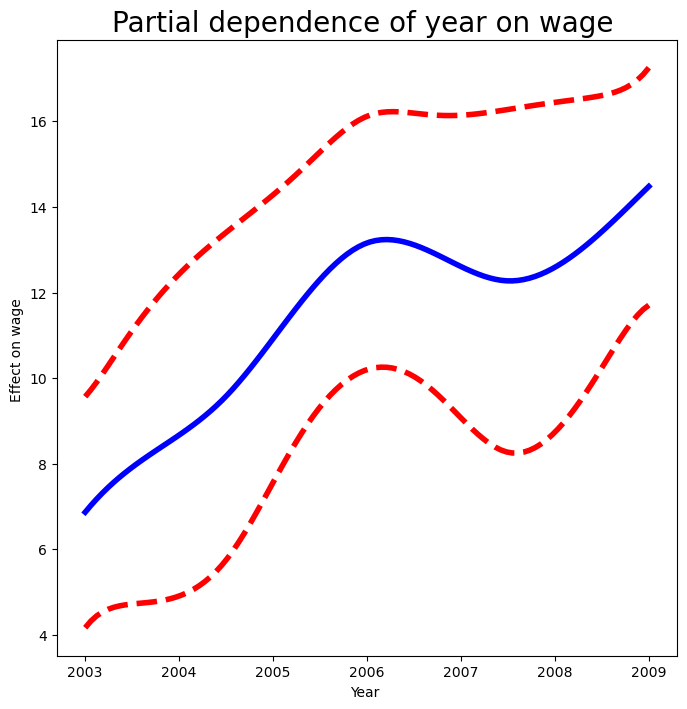

In [44]:
fig , ax = subplots(figsize =(8 ,8))
plot_gam(gam_full , 1, ax=ax)
ax.set_xlabel('Year ')
ax.set_ylabel('Effect on wage ')
ax.set_title('Partial dependence of year on wage ', fontsize =20)

## 📈 Partial Dependence Plot for Year (using `plot_gam`)

This section visualizes the effect of **year** on **wage** using a fitted GAM model from `pygam`, focusing on the smoothed function \( f_2(\text{year}) \).

---

### 🔧 Code

```python
fig, ax = subplots(figsize=(8, 8))
plot_gam(gam_full, 1, ax=ax)

ax.set_xlabel('Year')
ax.set_ylabel('Effect on wage')
ax.set_title('Partial dependence of year on wage', fontsize=20)
```

---

### 🧠 What Each Line Does

- **`fig, ax = subplots(figsize=(8, 8))`**  
  - Creates a figure and axis using Matplotlib  
  - Sets figure size to 8×8 inches for clarity

- **`plot_gam(gam_full, 1, ax=ax)`**  
  - Calls `plot_gam` from `ISLP.pygam` to create a **partial dependence plot**  
  - `gam_full`: The fitted `LinearGAM` object (refitted with df=5 for age and year)  
  - `1`: Index of the **year** term in `Xgam`  
  - `ax`: Axis object for the plot  

---

### ⚙️ What `plot_gam` Does Internally

- Generates a **grid of year values** (e.g., 2003 to 2009)
- Sets **other predictors** (age, education) to their **mean/reference** values
- Uses `gam_full.partial_dependence(...)` to:
  - Predict the effect of **year** while holding other variables constant
  - **Center** the predictions (subtracting the mean)
- **Plots** the centered predictions with **confidence intervals**

---

### 📘 Plot Labels

- `x-axis`: **"Year"**  
- `y-axis`: **"Effect on wage"** (centered contribution of year)  
- `title`: **"Partial dependence of year on wage"** with large font (fontsize=20)  

---

### 📌 Key Concepts

#### 📊 Partial Dependence Plot

- Visualizes the **effect of year** on wage, accounting for the average impact of **age and education**
- Plots the smoothed function \( f_2(\text{year}) \), centered to show relative change
- Confidence intervals reflect uncertainty in the smoothing spline fit

#### 🧮 Smoothing Spline for Year

- The **year** term is a smoothing spline:  
  ```python
  s_gam(1, n_splines=7)
  ```
- Degrees of freedom set to `df=5` via `approx_lam(...)` in previous steps
- `n_splines=7` aligns with 7 unique year values (e.g., 2003–2009)
- Higher `lam` from `approx_lam` → smoother curve, **less wiggle** than default `lam=0.6`

#### ✅ Why Use `plot_gam`?

- Automates the process of:
  - Building a prediction grid  
  - Holding other predictors constant  
  - Centering predictions  
  - Plotting with confidence intervals  
- More efficient and **less error-prone** than manual partial dependence construction

---

### 🧾 Summary

| Component        | Description                                               |
|------------------|-----------------------------------------------------------|
| `plot_gam(...)`  | Plots smoothed effect of `year` using GAM with df=5       |
| Effect displayed | Relative contribution of year to wage (centered)          |
| Smoothness       | Controlled using `approx_lam`, more stable than default   |
| Use case         | Clear, interpretable summary of how wage changes by year  |




[Text(0, 0, '1. < HS Grad'),
 Text(1, 0, '2. HS Grad'),
 Text(2, 0, '3. Some College'),
 Text(3, 0, '4. College Grad'),
 Text(4, 0, '5. Advanced Degree')]

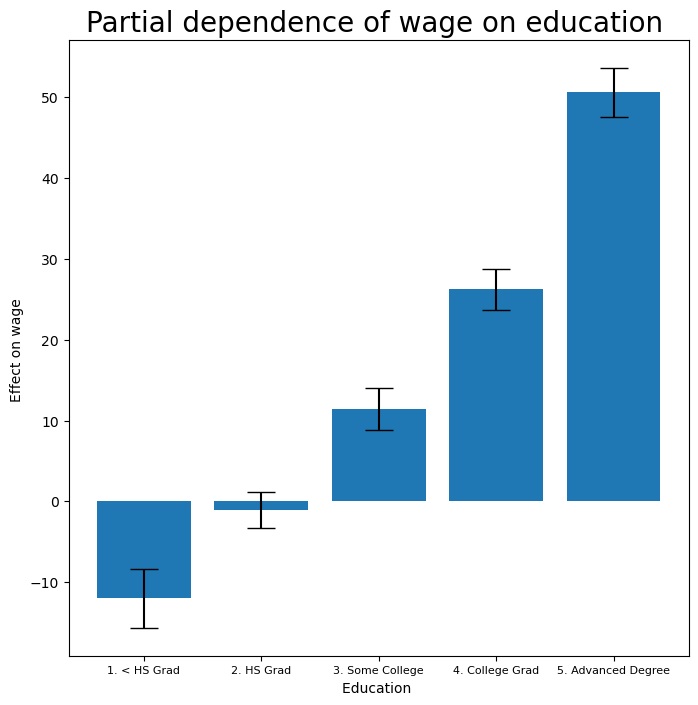

In [46]:
fig , ax = subplots(figsize =(8, 8))
ax = plot_gam(gam_full , 2)
ax.set_xlabel('Education ')
ax.set_ylabel('Effect on wage ')
ax.set_title('Partial dependence of wage on education ',fontsize =20)
ax.set_xticklabels(Wage['education'].cat.categories , fontsize =8)

## 🎓 Partial Dependence Plot for Education (using `plot_gam`)

This section visualizes the effect of **education level** on **wage** using the fitted `LinearGAM` model. Education is modeled as a **categorical variable** (via `f_gam` with `lam=0`).

---

### 🔧 Code

```python
fig, ax = subplots(figsize=(8, 8))
ax = plot_gam(gam_full, 2)

ax.set_xlabel('Education')
ax.set_ylabel('Effect on wage')
ax.set_title('Partial dependence of wage on education', fontsize=20)

ax.set_xticklabels(Wage['education'].cat.categories, fontsize=8)
```

---

### 🧠 What Each Line Does

- **`fig, ax = subplots(figsize=(8, 8))`**  
  - Initializes the Matplotlib figure and axis  
  - Sets figure size to 8×8 inches

- **`ax = plot_gam(gam_full, 2)`**  
  - Plots the **partial dependence** of the education term (index 2 in `Xgam`)  
  - `gam_full`: Fitted GAM model  
  - Internally:
    - Predicts wage at each **education level**
    - Sets **age and year** to their mean values
    - Centers the predictions
    - Adds confidence intervals

- **`ax.set_xlabel('Education')`**, **`ax.set_ylabel('Effect on wage')`**, **`ax.set_title(...)`**  
  - Adds axis labels and a plot title

- **`ax.set_xticklabels(Wage['education'].cat.categories, fontsize=8)`**  
  - Converts x-tick labels from **numeric codes (0–4)** to actual **education level names**  
  - Improves readability

---

### 📌 Key Concepts

#### 📊 Partial Dependence for Categorical Variables

- For continuous variables (like age or year): Plot is a **smooth curve**
- For categorical variables (like education): Plot shows **discrete values**  
  - Each level has a **constant effect**  
  - Displayed as **points, bars, or steps**  
  - Includes **confidence intervals** (e.g., error bars)

#### 🧮 Education Term: `f_gam(2, lam=0)`

- `f_gam`: Models education as a **factor (categorical variable)**  
- `lam=0`: No smoothing → acts like standard dummy variable encoding  
- Each level receives an **independent estimate** of its effect on wage

#### 🔢 Why Numeric Codes?

- `pygam` only accepts numeric matrices  
- `Wage['education'].cat.codes` maps education levels to integers (0, 1, 2, 3, 4)  
- `plot_gam` uses these internally, but we map back to readable labels

#### ⚖️ Centering

- Predictions are **centered** (i.e., mean effect is 0)  
- Y-axis shows **relative change in wage** across education levels

---

### 📈 Expected Output

| Component        | Description                                                  |
|------------------|--------------------------------------------------------------|
| **x-axis**       | Education levels: "< HS Grad", "HS Grad", ..., "Advanced Degree" |
| **y-axis**       | Centered wage effect (e.g., in $1000s)                        |
| **Plot**         |
